In [446]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.utils import Utils
import folium
from folium.plugins import HeatMap

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import kagglehub

##### First let's look at some empirical data measured by Louisville metro government

In [447]:
df_emp = pd.read_csv("./datasets/louisville_air_quality_empirical.csv")

In [448]:
df_emp

,Site Name,2018,2019,2020,2021,2022,2023,2024
0,Algonquin,9.6,9.1,8.1,9.0,7.9,9.6,7.9
1,Durrett Lane,10.1,9.6,8.8,9.9,8.4,10.2,7.9
2,Cannons Lane,8.9,8.4,7.9,8.7,7.3,9.1,7.2
3,Carrithers,NaN,8.4,7.9,8.8,7.9,9.5,7.3
4,Watson Lane,10.3,9.1,8.8,9.4,8.5,9.9,8.0
5,Jeffersonville,9.2,8.5,8.8,9.9,9.1,10.5,8.4
6,New Albany,NaN,NaN,NaN,NaN,NaN,8.4,6.5


In [449]:
years = list(df_emp.columns[1:])

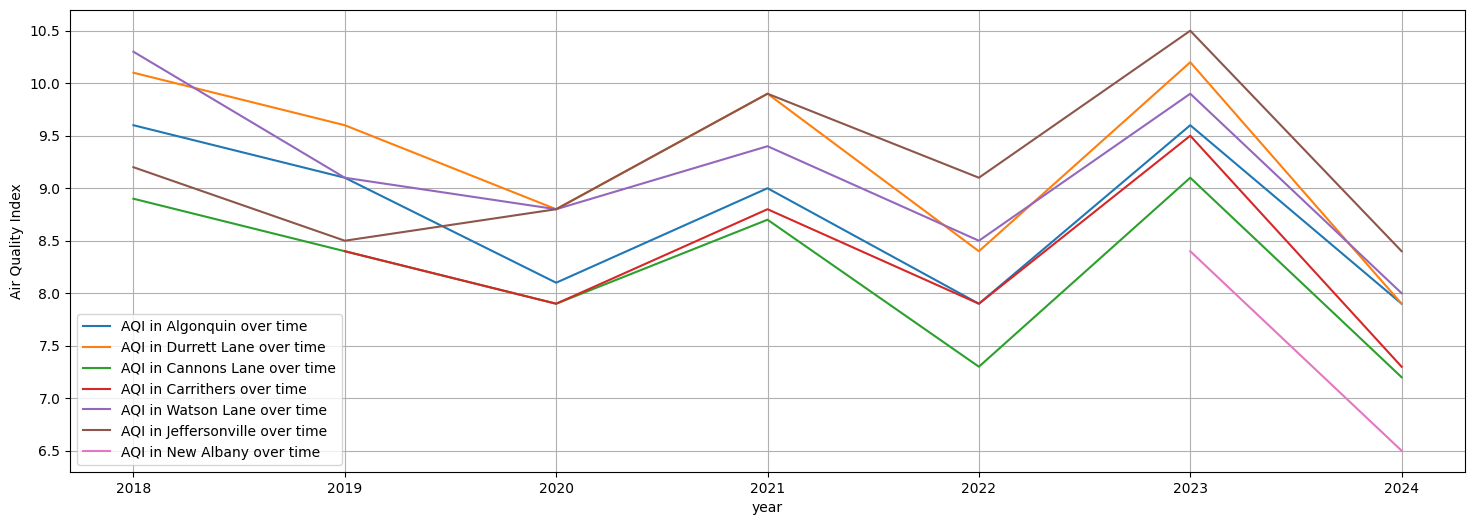

In [450]:
plt.figure(figsize=(18,6))
sites = df_emp["Site Name"]
for site in sites:
    data = list(df_emp[df_emp["Site Name"] == site].iloc[0, 1:])
    plt.plot(years, data, label="AQI in {} over time".format(site))
    plt.xlabel("year")
    plt.ylabel("Air Quality Index")
    plt.legend()
    plt.grid()

##### Now, let's look at the raw data we measured across louisville

In [451]:
df_meas = pd.read_csv("./datasets/Louisville pollution - air quality measurements.csv")

df_meas.head(5)

,Area,Coordinates,Time/Date,CO2 (ppm),TVOC (Total Volatile Organic compounds) (mg),HCHO (Formaldehyde) (mg),Temperature (Degrees F),Air humidity (fraction)
0,Rubber town (W),38.21197 N 85.84051 W,12:15 PM 12/8/2024,450,0.190,0.130,53,0.29
1,Louisville Airport(S),38.18604 N 85.74339 W,11:58 AM 12/8/2024,405,0.020,0.008,52,0.36
2,Jeffersontown (SE),38.18642 N 85.56060 W,6:30 PM 12/7/2024,405,0.020,0.006,39,0.20
3,Flat rock road (E),38.26705 N 85.44206 W,3:30 PM 12/7/2024,416,0.015,0.005,41,0.20
4,Prospect (N),38.24171 N 85.84051 W,12:52 PM 12/8/2024,424,0.015,0.010,54,0.31


##### We need to construct a measure of air quality using our formeldahyde, CO2, and TVOC that is comparable to the AQI from the empirical data

In [452]:
jtown_df = df_meas.query("Area == 'Jeffersontown (SE)'")
jtown_df

,Area,Coordinates,Time/Date,CO2 (ppm),TVOC (Total Volatile Organic compounds) (mg),HCHO (Formaldehyde) (mg),Temperature (Degrees F),Air humidity (fraction)
2,Jeffersontown (SE),38.18642 N 85.56060 W,6:30 PM 12/7/2024,405,0.020,0.006,39,0.2
9,Jeffersontown (SE),38.18642 N 85.56060 W,2:30 PM 12/14/2024,500,0.047,0.014,53,0.4
16,Jeffersontown (SE),38.18642 N 85.56060 W,3:10 PM 12/22/2024,412,0.021,0.014,34,0.2
23,Jeffersontown (SE),38.18642 N 85.56060 W,1:09 PM 12/30/2024,412,0.022,0.017,34,0.2


To convert ppm (parts per million) to g/m3 (grams per cubic meter), you need to multiply the ppm value by the molecular weight of the substance and divide by the molar volume of a gas at standard conditions (approximately 24.45 liters per mole), resulting in the concentration in g/m3: g/m3 = (ppm * Molecular Weight) / 24.45.

In [453]:
# compute volume that air monitor measures in meters
monitor_volume = (100 * 69 * 35) * (10 ** -3) ** 3

In [454]:
def ppm_to_mg_monitor(ppm, molar_mass, volume):
    return ((ppm * molar_mass) / 24.45) * volume

In [455]:
jtown_df["CO2 (mg)"] = jtown_df['CO2 (ppm)'].apply(ppm_to_mg_monitor, args=(44.01, 0.00024150000000000002,))

/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_34747/3015964343.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jtown_df["CO2 (mg)"] = jtown_df['CO2 (ppm)'].apply(ppm_to_mg_monitor, args=(44.01, 0.00024150000000000002,))


In [456]:
jtown_df

,Area,Coordinates,Time/Date,CO2 (ppm),TVOC (Total Volatile Organic compounds) (mg),HCHO (Formaldehyde) (mg),Temperature (Degrees F),Air humidity (fraction),CO2 (mg)
2,Jeffersontown (SE),38.18642 N 85.56060 W,6:30 PM 12/7/2024,405,0.020,0.006,39,0.2,0.176054
9,Jeffersontown (SE),38.18642 N 85.56060 W,2:30 PM 12/14/2024,500,0.047,0.014,53,0.4,0.217350
16,Jeffersontown (SE),38.18642 N 85.56060 W,3:10 PM 12/22/2024,412,0.021,0.014,34,0.2,0.179096
23,Jeffersontown (SE),38.18642 N 85.56060 W,1:09 PM 12/30/2024,412,0.022,0.017,34,0.2,0.179096


##### We need our air quality coefficient to be ~6.5-8.5

##### Using weights of [0.4, 0.3, 0.3] for the CO2, formeldahyde, and TVOC respectively, we get an AQ coefficient on the same order of magnitude as the empirical AQI

In [457]:
jtown_df["AQ computed coeff"] = 100 * 0.4 * jtown_df["CO2 (mg)"] + 0.3 * jtown_df["HCHO (Formaldehyde) (mg)"] + 0.3 * jtown_df["TVOC (Total Volatile Organic compounds) (mg)"]

/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_34747/4158118521.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jtown_df["AQ computed coeff"] = 100 * 0.4 * jtown_df["CO2 (mg)"] + 0.3 * jtown_df["HCHO (Formaldehyde) (mg)"] + 0.3 * jtown_df["TVOC (Total Volatile Organic compounds) (mg)"]


In [458]:
jtown_df

,Area,Coordinates,Time/Date,CO2 (ppm),TVOC (Total Volatile Organic compounds) (mg),HCHO (Formaldehyde) (mg),Temperature (Degrees F),Air humidity (fraction),CO2 (mg),AQ computed coeff
2,Jeffersontown (SE),38.18642 N 85.56060 W,6:30 PM 12/7/2024,405,0.020,0.006,39,0.2,0.176054,7.049940
9,Jeffersontown (SE),38.18642 N 85.56060 W,2:30 PM 12/14/2024,500,0.047,0.014,53,0.4,0.217350,8.712300
16,Jeffersontown (SE),38.18642 N 85.56060 W,3:10 PM 12/22/2024,412,0.021,0.014,34,0.2,0.179096,7.174356
23,Jeffersontown (SE),38.18642 N 85.56060 W,1:09 PM 12/30/2024,412,0.022,0.017,34,0.2,0.179096,7.175556


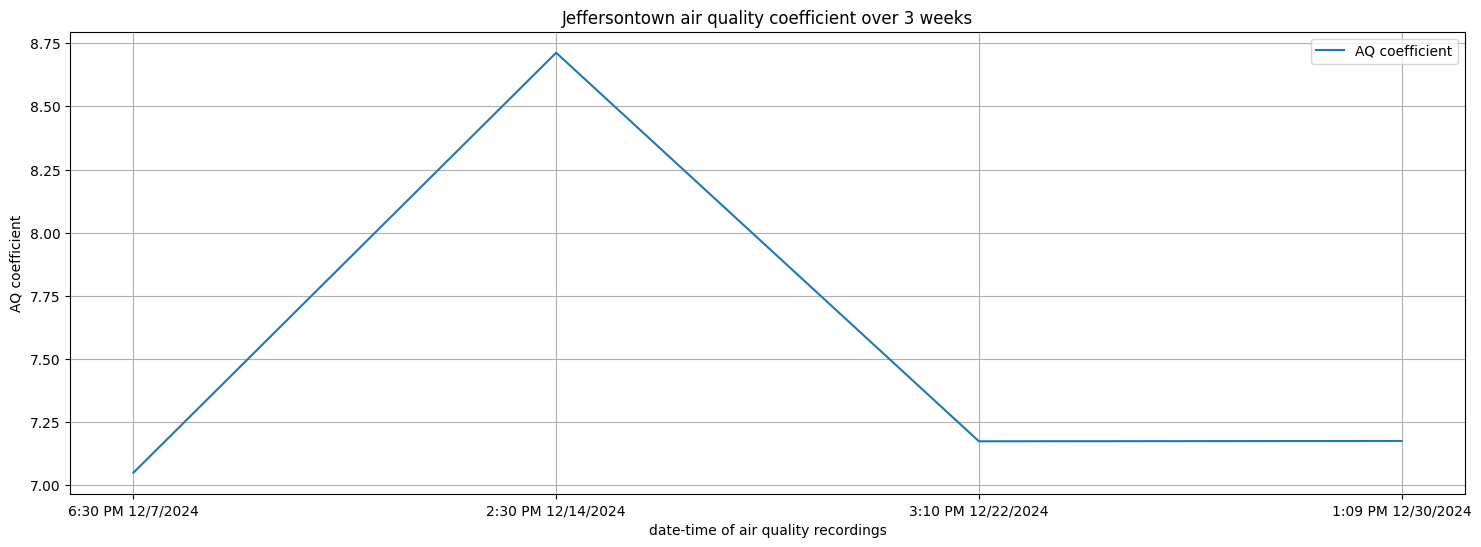

In [459]:
plt.figure(figsize=(18,6))
plt.plot(jtown_df["Time/Date"], jtown_df["AQ computed coeff"], label = "AQ coefficient")
plt.xlabel("date-time of air quality recordings")
plt.ylabel("AQ coefficient")
plt.title("Jeffersontown air quality coefficient over 3 weeks")
plt.legend()
plt.grid()

##### This isn't enough data points to forecast, let's cluster locations into western cluster, central cluster, eastern cluster based on proximity 

In [460]:
df_meas["loc_clusters"] = [0, 1, 2, 2, 0, 1, 1] * 4
df_meas[["Area", "loc_clusters"]].head(7) 

,Area,loc_clusters
0,Rubber town (W),0
1,Louisville Airport(S),1
2,Jeffersontown (SE),2
3,Flat rock road (E),2
4,Prospect (N),0
5,Mid-town,1
6,Downtown Meyzeek,1


Cluster 0: Western,
Cluster 1: Central,
Cluster 2: Eastern

##### We know our AQ coefficient model is accurate now, let's apply it to all of the areas

In [461]:
df_meas["CO2 (mg)"] = df_meas['CO2 (ppm)'].apply(ppm_to_mg_monitor, args=(44.01, monitor_volume,))
df_meas["AQI"] = 100 * 0.4 * df_meas["CO2 (mg)"] + 0.3 * df_meas["HCHO (Formaldehyde) (mg)"] + 0.3 * df_meas["TVOC (Total Volatile Organic compounds) (mg)"]
df_meas["Time/Date"] = pd.to_datetime(df_meas["Time/Date"], format="%I:%M %p %m/%d/%Y")
df_meas = df_meas.sort_values(by="Time/Date")

In [462]:
df_meas[["Area", "AQI"]].head(7)

,Area,AQI
3,Flat rock road (E),7.239408
5,Mid-town,9.237540
2,Jeffersontown (SE),7.049940
1,Louisville Airport(S),7.050540
0,Rubber town (W),7.920600
6,Downtown Meyzeek,7.053540
4,Prospect (N),7.380012


In [463]:
df_west = df_meas.query("loc_clusters == 0")
df_west = df_west.dropna()

df_cent = df_meas.query("loc_clusters == 1")
df_cent = df_cent.dropna()

df_east = df_meas.query("loc_clusters == 2")
df_east = df_east.dropna()


In [464]:
# df_east
df_meas

,Area,Coordinates,Time/Date,CO2 (ppm),TVOC (Total Volatile Organic compounds) (mg),HCHO (Formaldehyde) (mg),Temperature (Degrees F),Air humidity (fraction),loc_clusters,CO2 (mg),AQI
3,Flat rock road (E),38.26705 N 85.44206 W,2024-12-07 15:30:00,416,0.015,0.005,41,0.20,2,0.180835,7.239408
5,Mid-town,38.18888 N 85.64317 W,2024-12-07 17:40:00,530,0.062,0.011,40,0.60,1,0.230391,9.237540
2,Jeffersontown (SE),38.18642 N 85.56060 W,2024-12-07 18:30:00,405,0.020,0.006,39,0.20,2,0.176054,7.049940
1,Louisville Airport(S),38.18604 N 85.74339 W,2024-12-08 11:58:00,405,0.020,0.008,52,0.36,1,0.176054,7.050540
0,Rubber town (W),38.21197 N 85.84051 W,2024-12-08 12:15:00,450,0.190,0.130,53,0.29,0,0.195615,7.920600
6,Downtown Meyzeek,38.24171 N 85.74769 W,2024-12-08 12:36:00,405,0.026,0.012,54,0.39,1,0.176054,7.053540
4,Prospect (N),38.24171 N 85.84051 W,2024-12-08 12:52:00,424,0.015,0.010,54,0.31,0,0.184313,7.380012
9,Jeffersontown (SE),38.18642 N 85.56060 W,2024-12-14 14:30:00,500,0.047,0.014,53,0.40,2,0.217350,8.712300
12,Mid-town,38.18888 N 85.64317 W,2024-12-14 15:00:00,414,0.022,0.014,53,0.24,1,0.179966,7.209432
8,Louisville Airport(S),38.18604 N 85.74339 W,2024-12-14 15:20:00,689,0.074,0.021,52,0.30,1,0.299508,12.008832


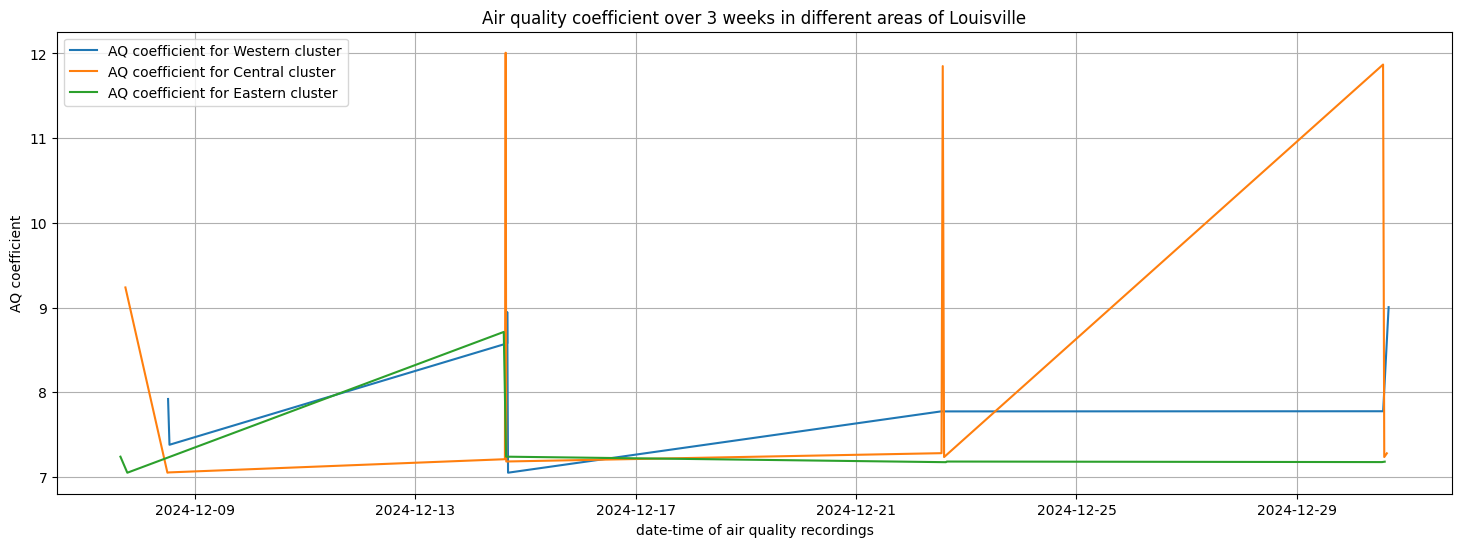

In [465]:
plt.figure(figsize=(18,6))
plt.plot(df_west["Time/Date"], df_west["AQI"], label = "AQ coefficient for Western cluster")
plt.plot(df_cent["Time/Date"], df_cent["AQI"], label = "AQ coefficient for Central cluster")
plt.plot(df_east["Time/Date"], df_east["AQI"], label = "AQ coefficient for Eastern cluster")
plt.xlabel("date-time of air quality recordings")
plt.ylabel("AQ coefficient")
plt.title("Air quality coefficient over 3 weeks in different areas of Louisville")
plt.legend()
plt.grid()

##### This gives our plot a lot of discontinuities, let's try doing the average of the locations on a given day to get a nicer looking plot

In [466]:
df_west["Date"] = df_west["Time/Date"].dt.date
df_days_west = df_west.groupby("Date")["AQI"].mean().reset_index()
df_days_west.columns = ["Date", "Average AQ Coefficient"]

df_cent["Date"] = df_cent["Time/Date"].dt.date
df_days_cent = df_cent.groupby("Date")["AQI"].mean().reset_index()
df_days_cent.columns = ["Date", "Average AQ Coefficient"]

df_east["Date"] = df_east["Time/Date"].dt.date
df_days_east = df_east.groupby("Date")["AQI"].mean().reset_index()
df_days_east.columns = ["Date", "Average AQ Coefficient"]

##### Let's plot as histograms since we don't have sequential time data anymore

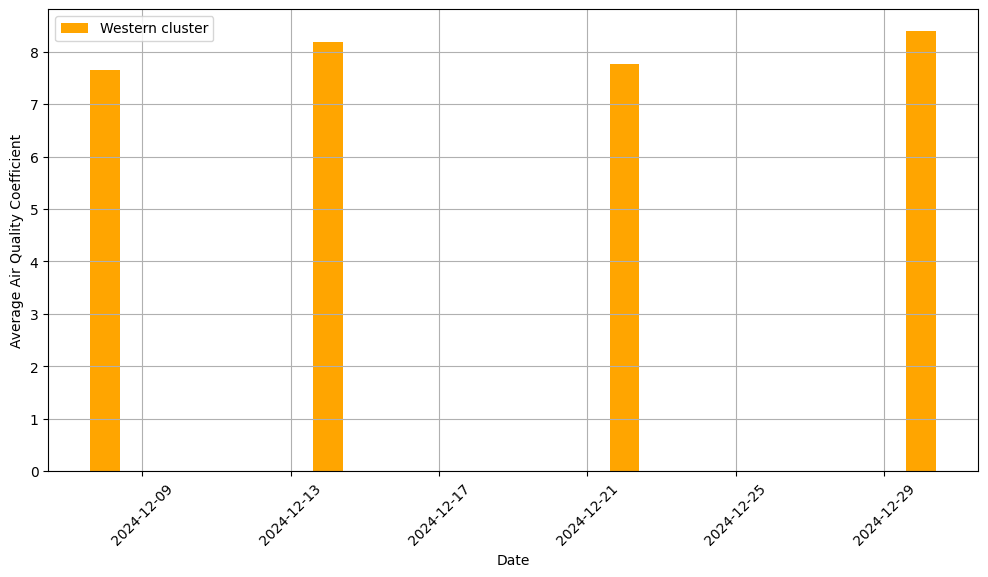

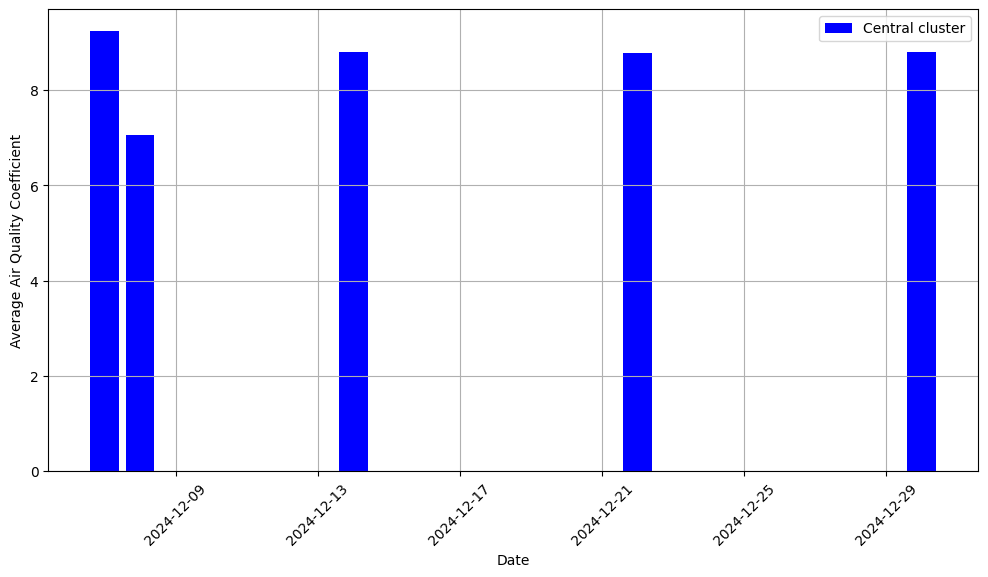

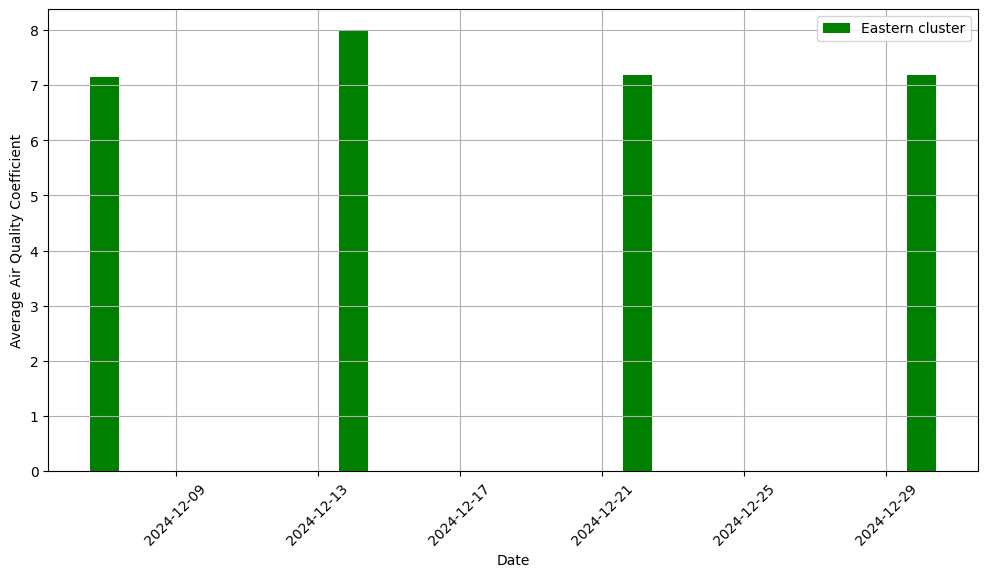

In [467]:
plt.figure(figsize=(12, 6))
plt.bar(
    df_days_west["Date"], 
    df_days_west["Average AQ Coefficient"],
    color="orange",
    label="Western cluster"
)
plt.xlabel("Date")
plt.ylabel("Average Air Quality Coefficient")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(12, 6))
plt.bar(
    df_days_cent["Date"], 
    df_days_cent["Average AQ Coefficient"],
    color="Blue",
    label="Central cluster"
)
plt.xlabel("Date")
plt.ylabel("Average Air Quality Coefficient")
plt.xticks(rotation=45)
plt.legend()
plt.grid()

plt.figure(figsize=(12, 6))
plt.bar(
    df_days_east["Date"], 
    df_days_east["Average AQ Coefficient"],
    color="Green",
    label="Eastern cluster"
)
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Average Air Quality Coefficient")
plt.legend()
plt.grid()



##### Using an average makes this looks relatively uniform, let's try creating a heat map

In [468]:
df_map = df_meas.dropna()
df_map

,Area,Coordinates,Time/Date,CO2 (ppm),TVOC (Total Volatile Organic compounds) (mg),HCHO (Formaldehyde) (mg),Temperature (Degrees F),Air humidity (fraction),loc_clusters,CO2 (mg),AQI
3,Flat rock road (E),38.26705 N 85.44206 W,2024-12-07 15:30:00,416,0.015,0.005,41,0.20,2,0.180835,7.239408
5,Mid-town,38.18888 N 85.64317 W,2024-12-07 17:40:00,530,0.062,0.011,40,0.60,1,0.230391,9.237540
2,Jeffersontown (SE),38.18642 N 85.56060 W,2024-12-07 18:30:00,405,0.020,0.006,39,0.20,2,0.176054,7.049940
1,Louisville Airport(S),38.18604 N 85.74339 W,2024-12-08 11:58:00,405,0.020,0.008,52,0.36,1,0.176054,7.050540
0,Rubber town (W),38.21197 N 85.84051 W,2024-12-08 12:15:00,450,0.190,0.130,53,0.29,0,0.195615,7.920600
6,Downtown Meyzeek,38.24171 N 85.74769 W,2024-12-08 12:36:00,405,0.026,0.012,54,0.39,1,0.176054,7.053540
4,Prospect (N),38.24171 N 85.84051 W,2024-12-08 12:52:00,424,0.015,0.010,54,0.31,0,0.184313,7.380012
9,Jeffersontown (SE),38.18642 N 85.56060 W,2024-12-14 14:30:00,500,0.047,0.014,53,0.40,2,0.217350,8.712300
12,Mid-town,38.18888 N 85.64317 W,2024-12-14 15:00:00,414,0.022,0.014,53,0.24,1,0.179966,7.209432
8,Louisville Airport(S),38.18604 N 85.74339 W,2024-12-14 15:20:00,689,0.074,0.021,52,0.30,1,0.299508,12.008832


In [469]:
def parse_coordinates(coord):
    lat, lon = coord.split(" N ")[0], coord.split(" N ")[1].replace(" W", "")
    return float(lat), -float(lon)

In [470]:
df_map["Latitude"], df_map["Longitude"] = zip(*df_map["Coordinates"].apply(parse_coordinates))

map_center = [df_map["Latitude"].mean(), df_map["Longitude"].mean()]
air_quality_map = folium.Map(location=map_center, zoom_start=12)
heat_data = [[row["Latitude"], row["Longitude"], row["AQI"]] for _, row in df_map.iterrows()]
HeatMap(heat_data, radius=15, max_zoom=13).add_to(air_quality_map)


air_quality_map.save("AQ_heatmap_lou.html")
air_quality_map

##### We've done some EDA on our findings, now let's look at using these findings as arguments to a linear model so we can forecast the AQ. We will use raw data from [SOURCE] to construct a linear model and then project into the future and see which has the worst air quality.

##### Using US AQI data from the EPA, let's build our linear model for Louisville

In [471]:
path = kagglehub.dataset_download("calebreigada/us-air-quality-1980present")
df_us = pd.read_csv("/Users/rahilshaik/.cache/kagglehub/datasets/calebreigada/us-air-quality-1980present/versions/1/US_AQI.csv")

In [472]:
df_ky = df_us.query("state_name == 'Kentucky'")
df_ky.head(5)

,Unnamed: 0,CBSA Code,Date,AQI,Category,Defining Parameter,Number of Sites Reporting,city_ascii,state_id,state_name,lat,lng,population,density,timezone
2694,2753,14540,2022-01-01,30,Good,Ozone,1,Bowling Green,KY,Kentucky,36.9716,-86.4378,94555.0,684.0,America/Chicago
2695,2754,14540,2022-01-02,30,Good,Ozone,1,Bowling Green,KY,Kentucky,36.9716,-86.4378,94555.0,684.0,America/Chicago
2696,2755,14540,2022-01-03,33,Good,Ozone,1,Bowling Green,KY,Kentucky,36.9716,-86.4378,94555.0,684.0,America/Chicago
2697,2756,14540,2022-01-04,29,Good,Ozone,1,Bowling Green,KY,Kentucky,36.9716,-86.4378,94555.0,684.0,America/Chicago
2698,2757,14540,2022-01-05,32,Good,Ozone,1,Bowling Green,KY,Kentucky,36.9716,-86.4378,94555.0,684.0,America/Chicago


In [473]:
print(df_ky["city_ascii"].unique())

['Bowling Green' 'Elizabethtown' 'Lexington' 'Middlesborough' 'Owensboro'
 'Paducah' 'Somerset' 'Richmond' 'Frankfort' 'London' 'Mayfield'
 'Central City' 'Maysville' 'Glasgow' 'Madisonville' 'Murray' 'Danville']


##### It looks like there isn't data for Louisville specifically, so let's model using lexington data

In [474]:
df_lex = df_ky.query("city_ascii == 'Lexington'")

In [475]:
df_lex["Date"] = pd.to_datetime(df_lex["Date"])
df_lex = df_lex.sort_values(by="Date")

/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_34747/1208013094.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lex["Date"] = pd.to_datetime(df_lex["Date"])


In [476]:
df_lex.head(5)

,Unnamed: 0,CBSA Code,Date,AQI,Category,Defining Parameter,Number of Sites Reporting,city_ascii,state_id,state_name,lat,lng,population,density,timezone
5575078,5675074,30460,1980-01-01,11,Good,NO2,2,Lexington,KY,Kentucky,38.0423,-84.4587,316743.0,438.0,America/New_York
5575079,5675075,30460,1980-01-02,23,Good,NO2,2,Lexington,KY,Kentucky,38.0423,-84.4587,316743.0,438.0,America/New_York
5575080,5675076,30460,1980-01-03,23,Good,NO2,2,Lexington,KY,Kentucky,38.0423,-84.4587,316743.0,438.0,America/New_York
5575081,5675077,30460,1980-01-04,25,Good,NO2,2,Lexington,KY,Kentucky,38.0423,-84.4587,316743.0,438.0,America/New_York
5575082,5675078,30460,1980-01-05,30,Good,NO2,2,Lexington,KY,Kentucky,38.0423,-84.4587,316743.0,438.0,America/New_York


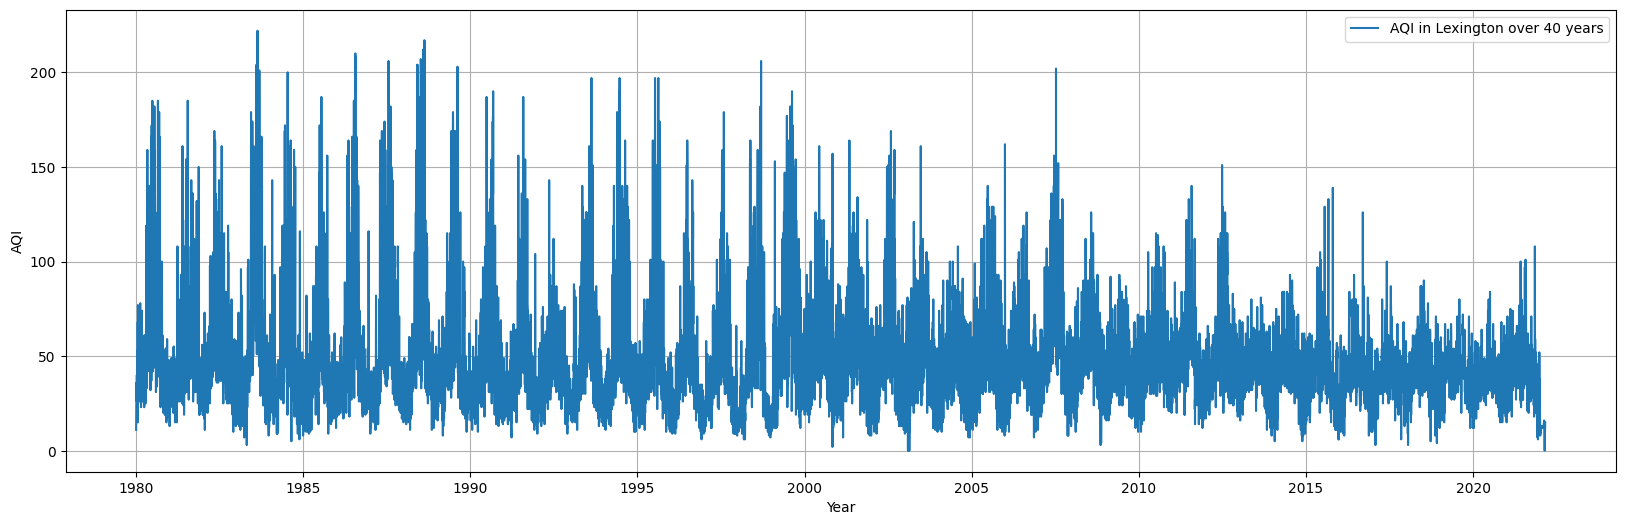

In [477]:
plt.figure(figsize=(20,6))
plt.plot(df_lex["Date"], df_lex["AQI"], label="AQI in Lexington over 40 years")
plt.xlabel("Year")
plt.ylabel("AQI")
plt.grid()
plt.legend()

##### Plotting a heat map so we can interpret this a bit

In [478]:
map_center = [df_lex["lat"].mean(), df_lex["lng"].mean()]
air_quality_map = folium.Map(location=map_center, zoom_start=12)
heat_data = [[row["lat"], row["lng"], row["AQI"]] for _, row in df_lex.iterrows()]
HeatMap(heat_data, radius=15, max_zoom=13).add_to(air_quality_map)


air_quality_map.save("AQ_heatmap_lex.html")
air_quality_map

##### Looks like these lexington recordings are only taken at one AQ monitor, but this should suffice for a linear model

##### Let's chunk our data into years so we can avoid overfitting

In [479]:
df_2014 = df_lex[df_lex["Date"].dt.year == 2014]
df_2015 = df_lex[df_lex["Date"].dt.year == 2015]
df_2016 = df_lex[df_lex["Date"].dt.year == 2016]
df_2014.head(5)

,Unnamed: 0,CBSA Code,Date,AQI,Category,Defining Parameter,Number of Sites Reporting,city_ascii,state_id,state_name,lat,lng,population,density,timezone
1285518,1309272,30460,2014-01-01,25,Good,NO2,1,Lexington,KY,Kentucky,38.0423,-84.4587,316743.0,438.0,America/New_York
1285519,1309273,30460,2014-01-02,37,Good,PM2.5,1,Lexington,KY,Kentucky,38.0423,-84.4587,316743.0,438.0,America/New_York
1285520,1309274,30460,2014-01-03,21,Good,NO2,1,Lexington,KY,Kentucky,38.0423,-84.4587,316743.0,438.0,America/New_York
1285521,1309275,30460,2014-01-04,12,Good,PM2.5,1,Lexington,KY,Kentucky,38.0423,-84.4587,316743.0,438.0,America/New_York
1285522,1309276,30460,2014-01-05,27,Good,PM2.5,1,Lexington,KY,Kentucky,38.0423,-84.4587,316743.0,438.0,America/New_York


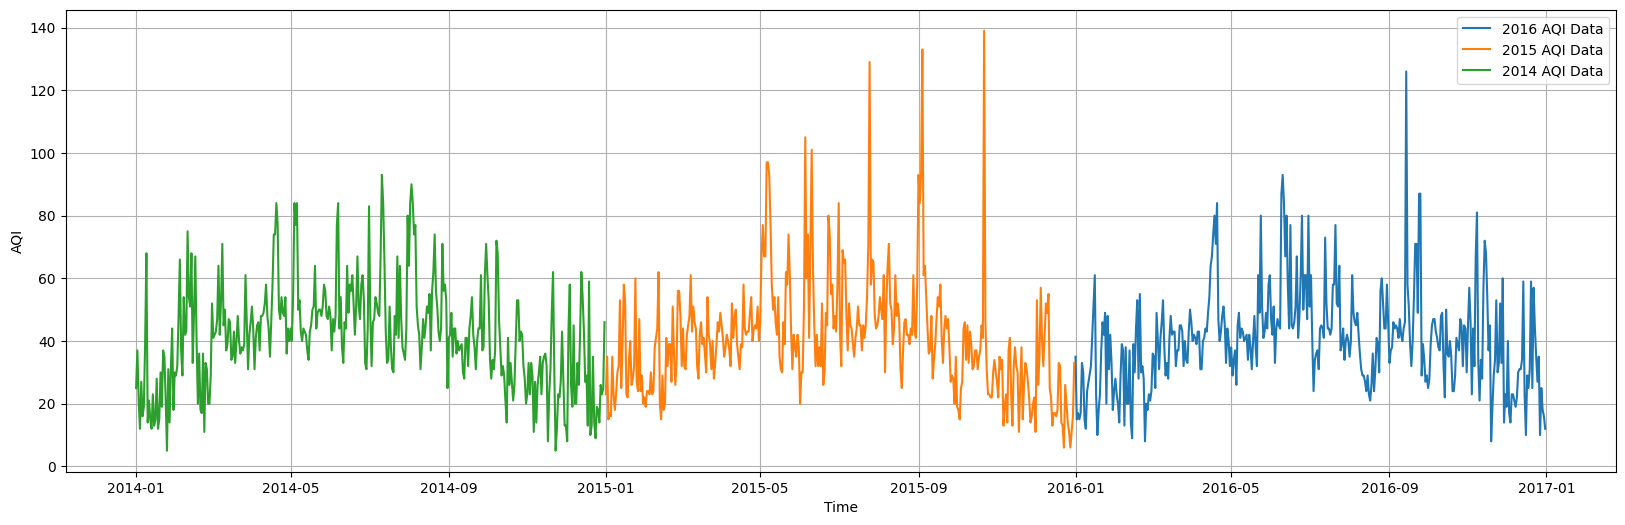

In [480]:
plt.figure(figsize=(20,6))
plt.plot(df_2016["Date"], df_2016["AQI"], label="2016 AQI Data")
plt.plot(df_2015["Date"], df_2015["AQI"], label="2015 AQI Data")
plt.plot(df_2014["Date"], df_2014["AQI"], label="2014 AQI Data")
plt.xlabel("Time")
plt.ylabel("AQI")
plt.grid()
plt.legend()

##### Each year shows roughly the same behavior so we can train on each eyar (ie train test split 80/20)

In [481]:
df_2014["float_time"] = df_2014["Date"].apply(lambda x: x.timestamp())

X = np.array(df_2014["float_time"])
y = np.array(list(df_2014["AQI"]))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LinearRegression()
model.fit(X_train.reshape(-1,1), y_train)

y_pred = model.predict(X_test.reshape(-1, 1))

mse = mean_squared_error(y_test, y_pred)
r_square = r2_score(y_test, y_pred)
print(mse)
print(r_square)


270.2595353541253
0.0012669108331710977


/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_34747/1352740617.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2014["float_time"] = df_2014["Date"].apply(lambda x: x.timestamp())


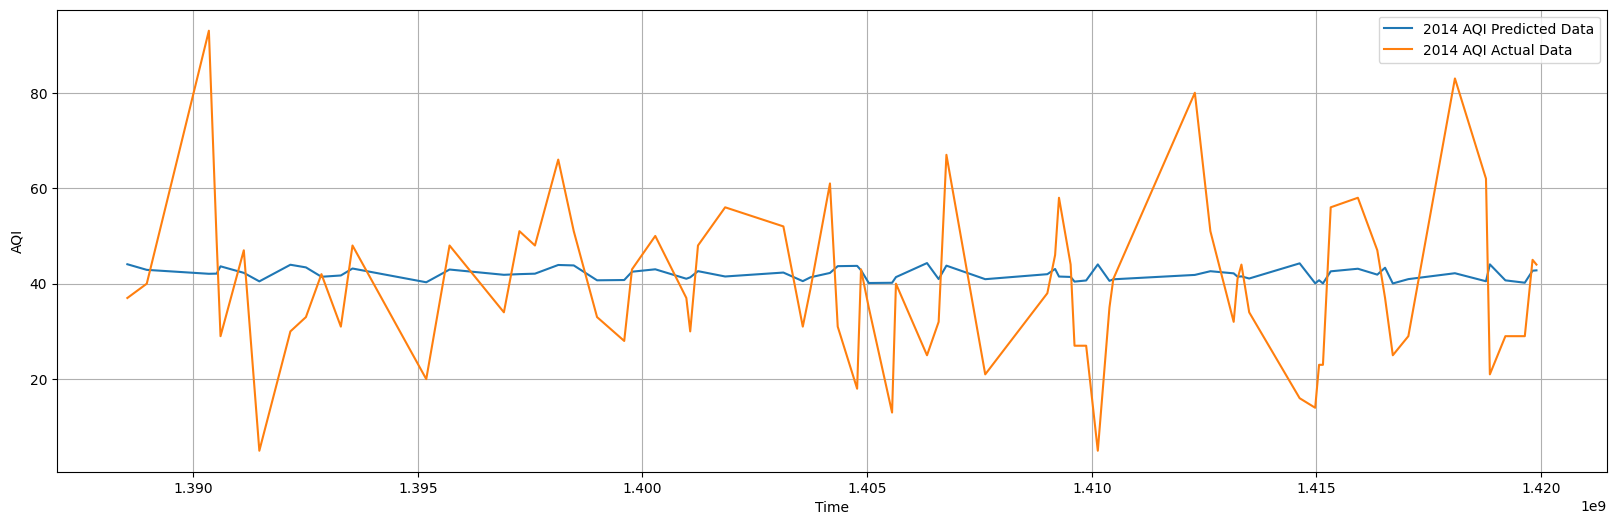

In [482]:
plt.figure(figsize=(20,6))
plt.plot(sorted(X_test), y_pred, label="2014 AQI Predicted Data")
plt.plot(sorted(X_test), y_test, label = "2014 AQI Actual Data")
plt.xlabel("Time")
plt.ylabel("AQI")
plt.grid()
plt.legend()

##### This is a very high MSE and looks like a lot of variance, let's try merging 2014 and 2015 to collect more training data

In [483]:
df_14_15 = pd.concat([df_2014, df_2015], ignore_index=True, axis=0)

In [484]:
df_14_15["float_time"] = df_14_15["Date"].apply(lambda x: x.timestamp())

X = np.array(df_14_15["float_time"])
y = np.array(list(df_14_15["AQI"]))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LinearRegression()
model.fit(X_train.reshape(-1,1), y_train)

y_pred = model.predict(X_test.reshape(-1, 1))
r_square = r2_score(y_test, y_pred)
print(r_square)

-0.022095009956972333


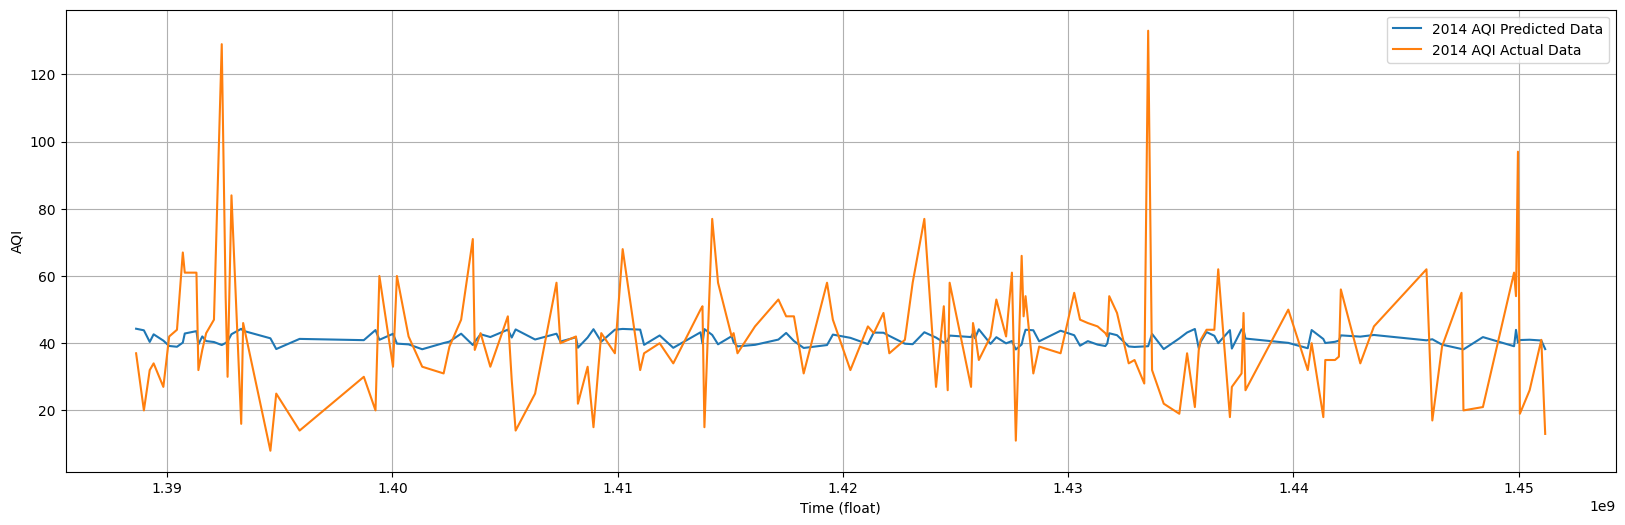

In [485]:
plt.figure(figsize=(20,6))
plt.plot(sorted(X_test), y_pred, label="2014 AQI Predicted Data")
plt.plot(sorted(X_test), y_test, label = "2014 AQI Actual Data")
plt.xlabel("Time (float)")
plt.ylabel("AQI")
plt.grid()
plt.legend()

##### Wow that is quite inaccurate as well, I'm just going to use all of the lexington data and see if I can get a good r squared value

In [486]:
df_lex["float_time"] = df_lex["Date"].apply(lambda x: x.timestamp())

X = np.array(df_lex["float_time"])
y = np.array(list(df_lex["AQI"]))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LinearRegression()
model.fit(X_train.reshape(-1,1), y_train)

y_pred = model.predict(X_test.reshape(-1, 1))
r_square = r2_score(y_test, y_pred)

print(r_square)

0.02244632186864326


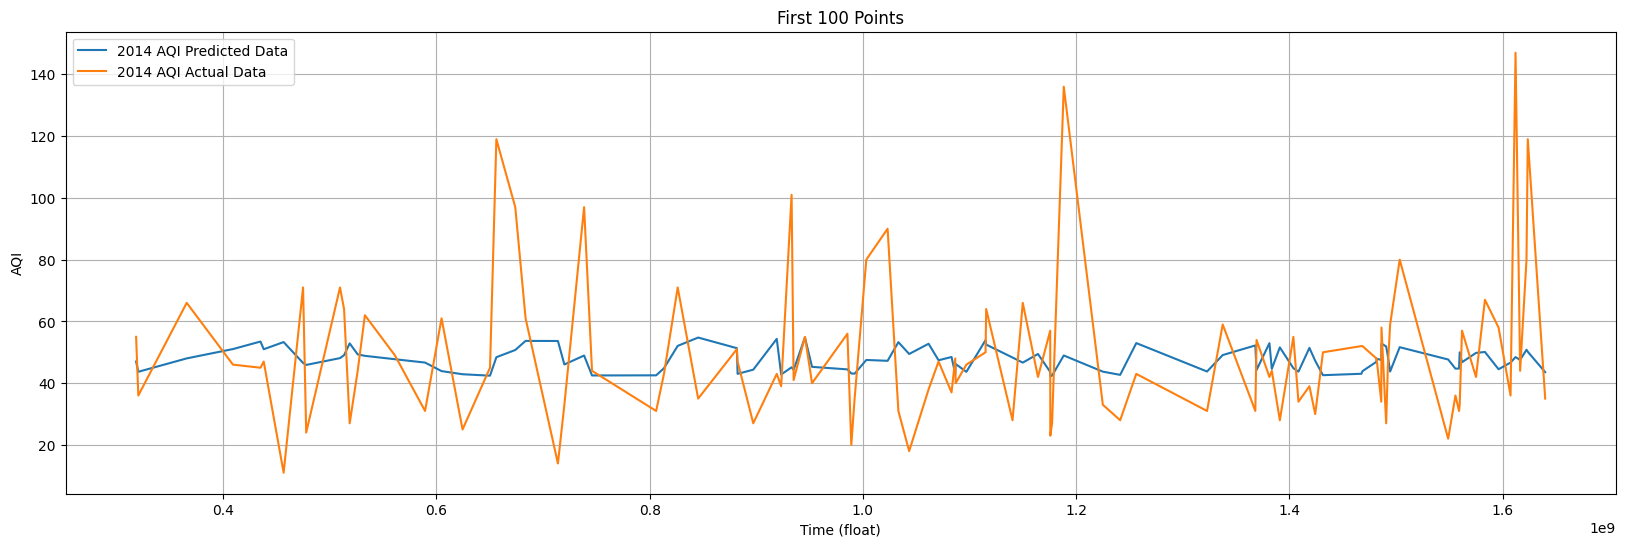

In [487]:
plt.figure(figsize=(20,6))
plt.plot(sorted(X_test[:100]), y_pred[:100], label="2014 AQI Predicted Data")
plt.plot(sorted(X_test[:100]), y_test[:100], label = "2014 AQI Actual Data")
plt.title("First 100 Points")
plt.xlabel("Time (float)")
plt.ylabel("AQI")
plt.grid()
plt.legend()

##### We can certainly see our linear model somewhat mirroring trends but is not able to do so accurately, the predicted data is a lot lower variance than the actual AQI data

##### I'm going to try adding a new feature with the "Defining Parameter" column to see if it improves the AQI prediction 

In [488]:
le = LabelEncoder()
df_lex['Defining_Parameter_Encoded'] = le.fit_transform(df_lex['Defining Parameter'])
features = ['float_time']

In [489]:
X = df_lex[features].dropna()
y = df_lex['AQI']
y = y[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r_square = r2_score(y_test, y_pred)

print(f"R-squared Score: {r_square}")

R-squared Score: 0.019492648184367356


##### Actually, defining parameter does not do anything for R^2 so let's ignore that

In [490]:
X_test.head(5)

,float_time
2586717,1.144368e+09
3479623,9.587808e+08
278934,1.593562e+09
1450456,1.383696e+09
4592493,6.810048e+08


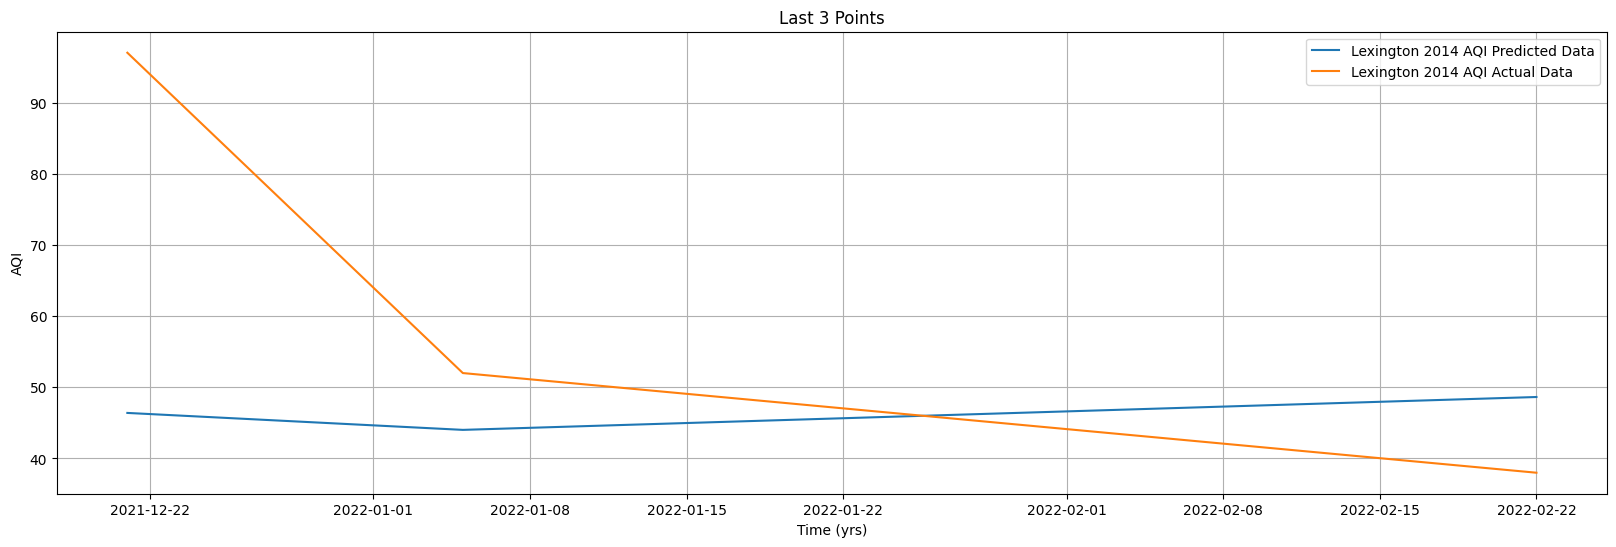

In [491]:
plt.figure(figsize=(20,6))
X_test["date-time"] = pd.to_datetime(X_test["float_time"], unit='s')
X_test = X_test.sort_values(by="date-time")
plt.plot(X_test["date-time"].tail(3), y_pred[-3:], label="Lexington 2014 AQI Predicted Data")
plt.plot(X_test["date-time"].tail(3), y_test[-3:], label = "Lexington 2014 AQI Actual Data")
plt.title("Last 3 Points")
plt.xlabel("Time (yrs)")
plt.ylabel("AQI")
plt.grid()
plt.legend()

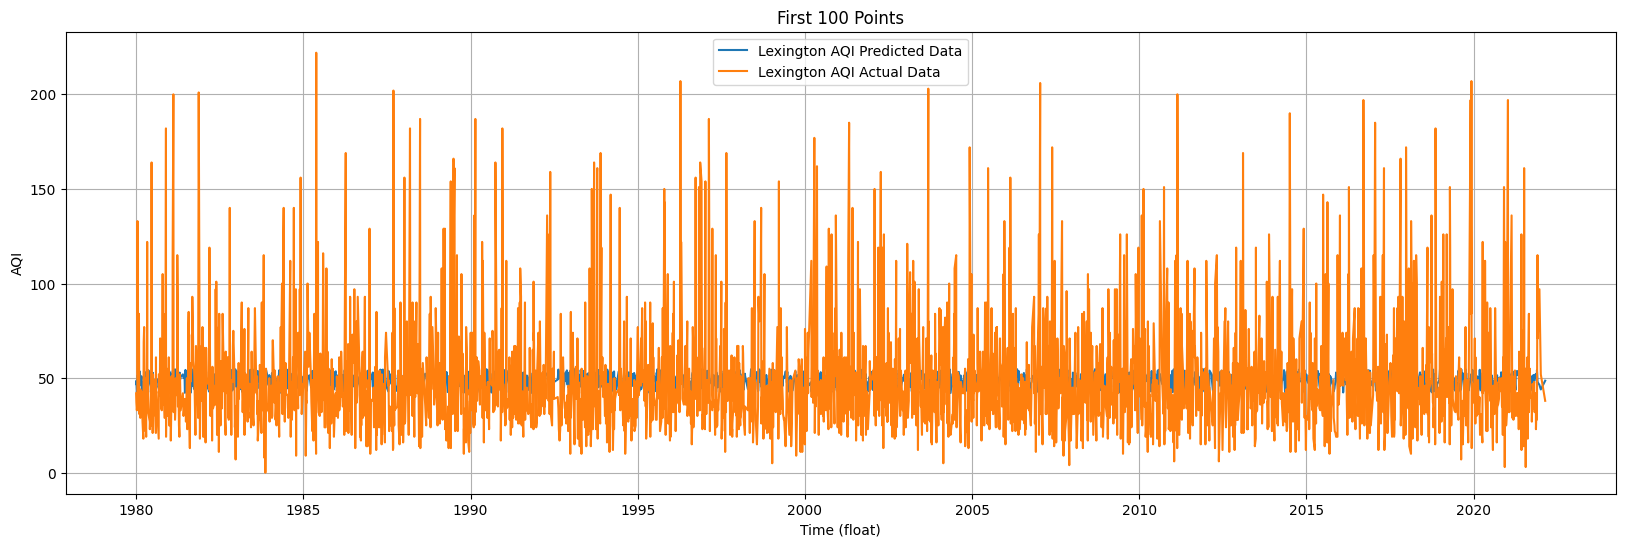

In [492]:
plt.figure(figsize=(20,6))
X_test["date-time"] = pd.to_datetime(X_test["float_time"], unit='s')
plt.plot((X_test["date-time"]), y_pred, label="Lexington AQI Predicted Data")
plt.plot((X_test["date-time"]), y_test, label = "Lexington AQI Actual Data")
plt.title("First 100 Points")
plt.xlabel("Time (float)")
plt.ylabel("AQI")
plt.grid()
plt.legend()

##### Now that we have this AQI model, let's predict AQI in the future

In [493]:
timestamps = np.array([
    1646107200,  # March 1, 2022
    1648780800,  # April 1, 2022
    1651454400,  # May 1, 2022
    1654138000,  # June 1, 2022
    1656811600,  # July 1, 2022
    1659485200,  # August 1, 2022
    1662168800,  # September 1, 2022
    1664852400,  # October 1, 2022
    1667536000,  # November 1, 2022
    1670219600,  # December 1, 2022
    1672903200,  # January 1, 2023
    1675586800,  # February 1, 2023
    1678270400,  # March 1, 2023
])

In [494]:
future_years = pd.DataFrame({'float_time': timestamps}) # 10 years
future_predictions = model.predict(future_years)

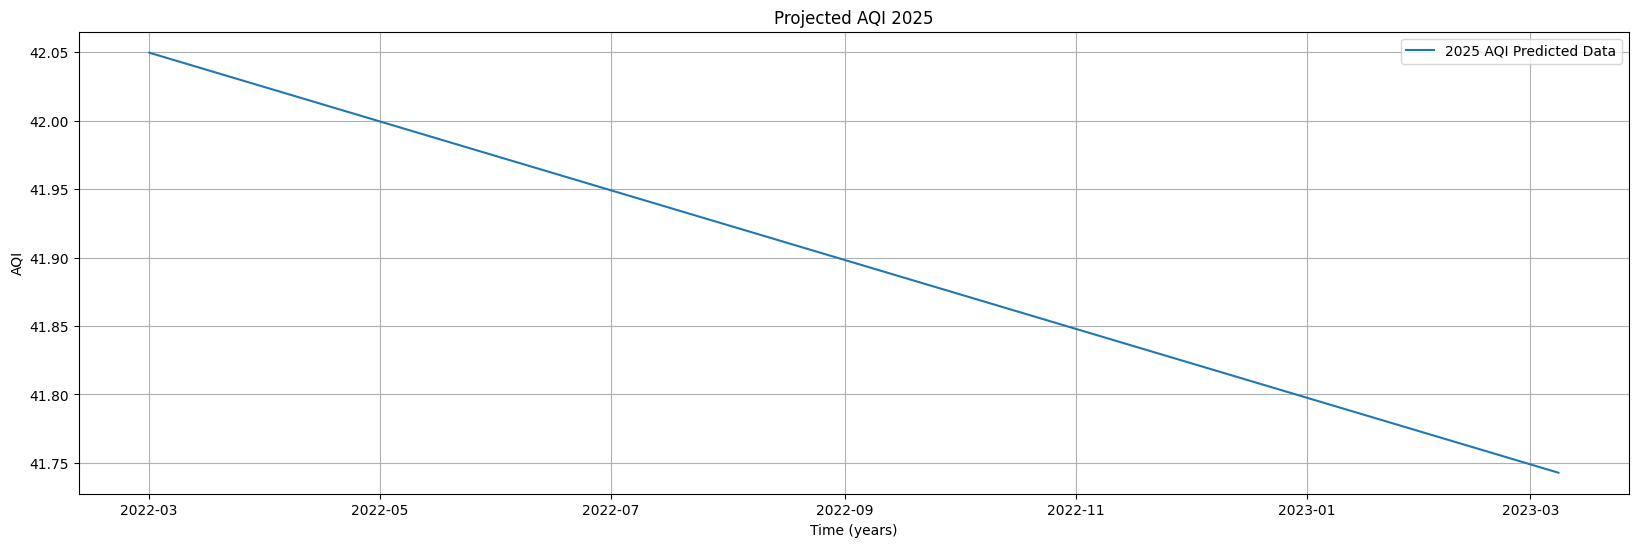

In [495]:
plt.figure(figsize=(20,6))
future_years["date-time"] = pd.to_datetime(future_years["float_time"], unit='s')
plt.plot(sorted(future_years["date-time"]), future_predictions, label="2025 AQI Predicted Data")
plt.title("Projected AQI 2025")
plt.xlabel("Time (years)")
plt.ylabel("AQI")
plt.grid()
plt.legend()

##### Oh lol. Won't use this in the project but I want to try a non linear model at some point

##### Let's do this projection on the data we have for the different clusters

In [496]:
df_meas.head(1)

,Area,Coordinates,Time/Date,CO2 (ppm),TVOC (Total Volatile Organic compounds) (mg),HCHO (Formaldehyde) (mg),Temperature (Degrees F),Air humidity (fraction),loc_clusters,CO2 (mg),AQI
3,Flat rock road (E),38.26705 N 85.44206 W,2024-12-07 15:30:00,416,0.015,0.005,41,0.2,2,0.180835,7.239408


In [497]:
df_meas = df_meas.dropna()
df_meas["Time/Date"] = pd.to_datetime(df_meas["Time/Date"])
df_meas["float_time"] = df_meas["Time/Date"].apply(lambda x: x.timestamp())

df_jtown = df_meas.query("Area == 'Jeffersontown (SE)'")

X_train = np.array(df_jtown[["float_time"]])
y_train = np.array(df_jtown[["AQI"]])

In [498]:
model.fit(X_train.reshape(-1, 1), y_train)
y_pred = model.predict(timestamps.reshape(-1, 1))

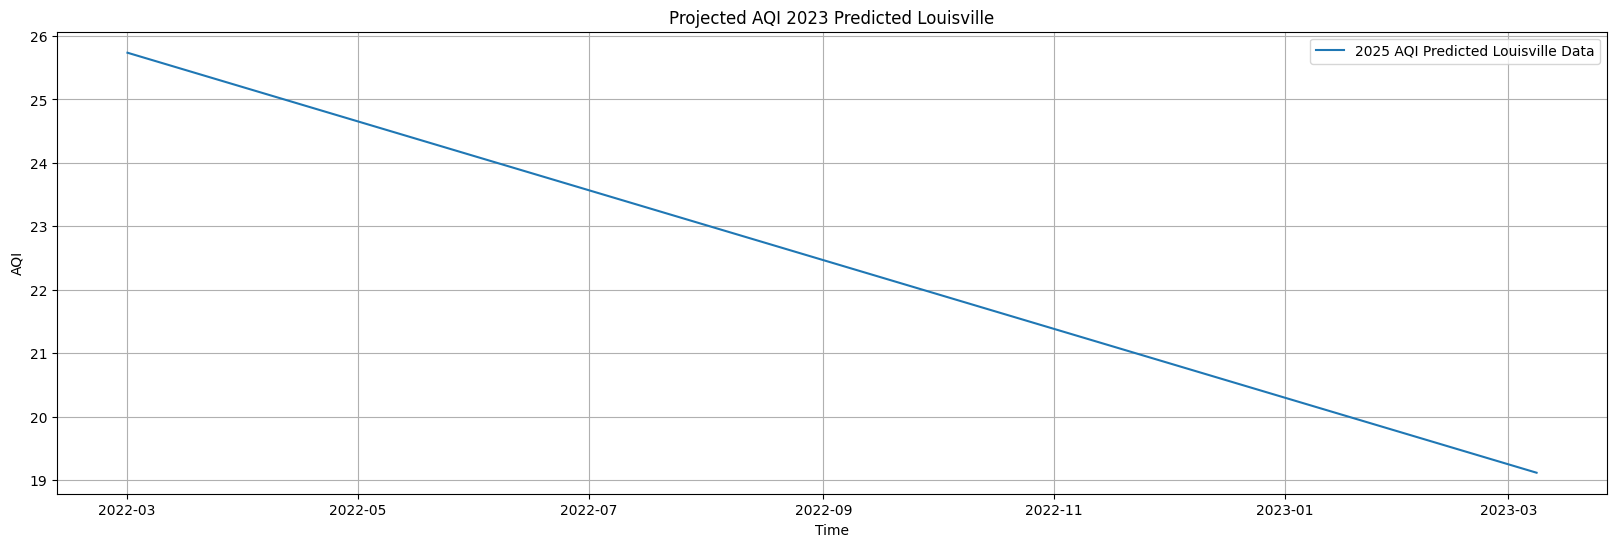

In [499]:
plt.figure(figsize=(20,6))
years = pd.to_datetime(timestamps, unit = 's')
plt.plot(years, y_pred, label="2025 AQI Predicted Louisville Data")
plt.title("Projected AQI 2023 Predicted Louisville")
plt.xlabel("Time")
plt.ylabel("AQI")
plt.grid()
plt.legend()

##### Let's do linear regression predictions for all the locations we collected data for

/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_34747/1456205753.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_location["Datetime"] = pd.to_datetime(df_location["float_time"], unit='s')


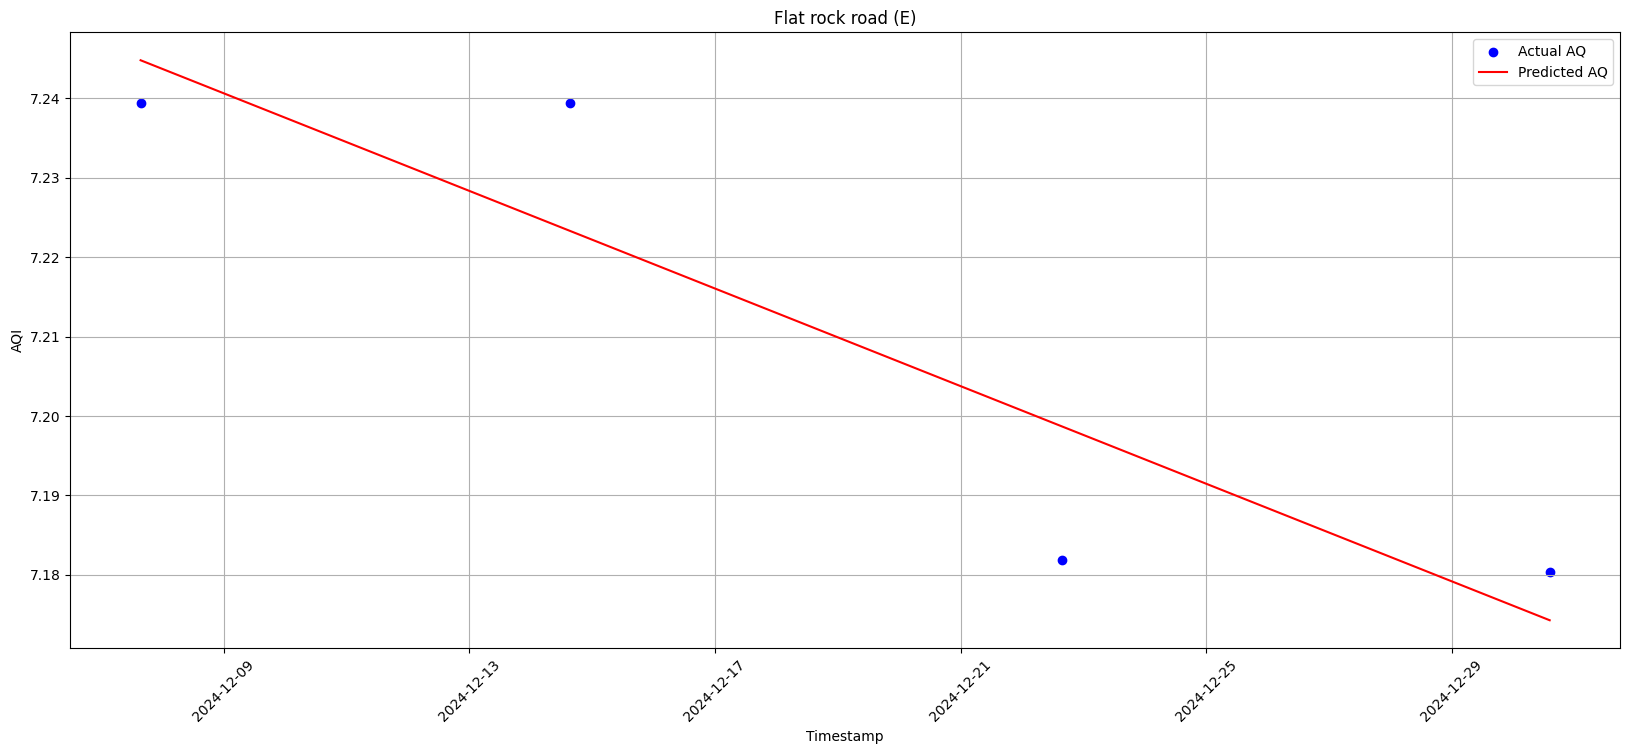

/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_34747/1456205753.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_location["Datetime"] = pd.to_datetime(df_location["float_time"], unit='s')


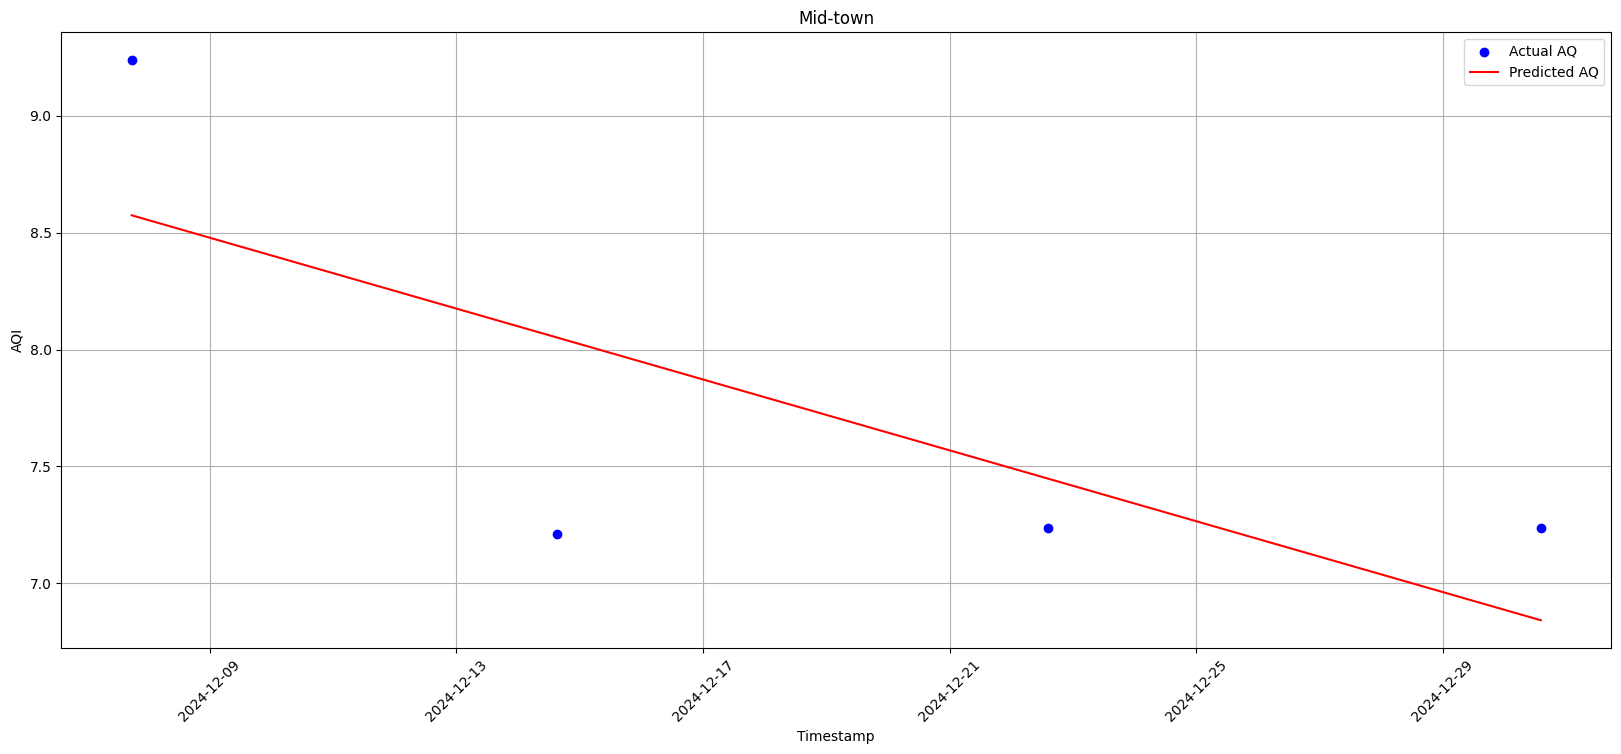

/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_34747/1456205753.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_location["Datetime"] = pd.to_datetime(df_location["float_time"], unit='s')


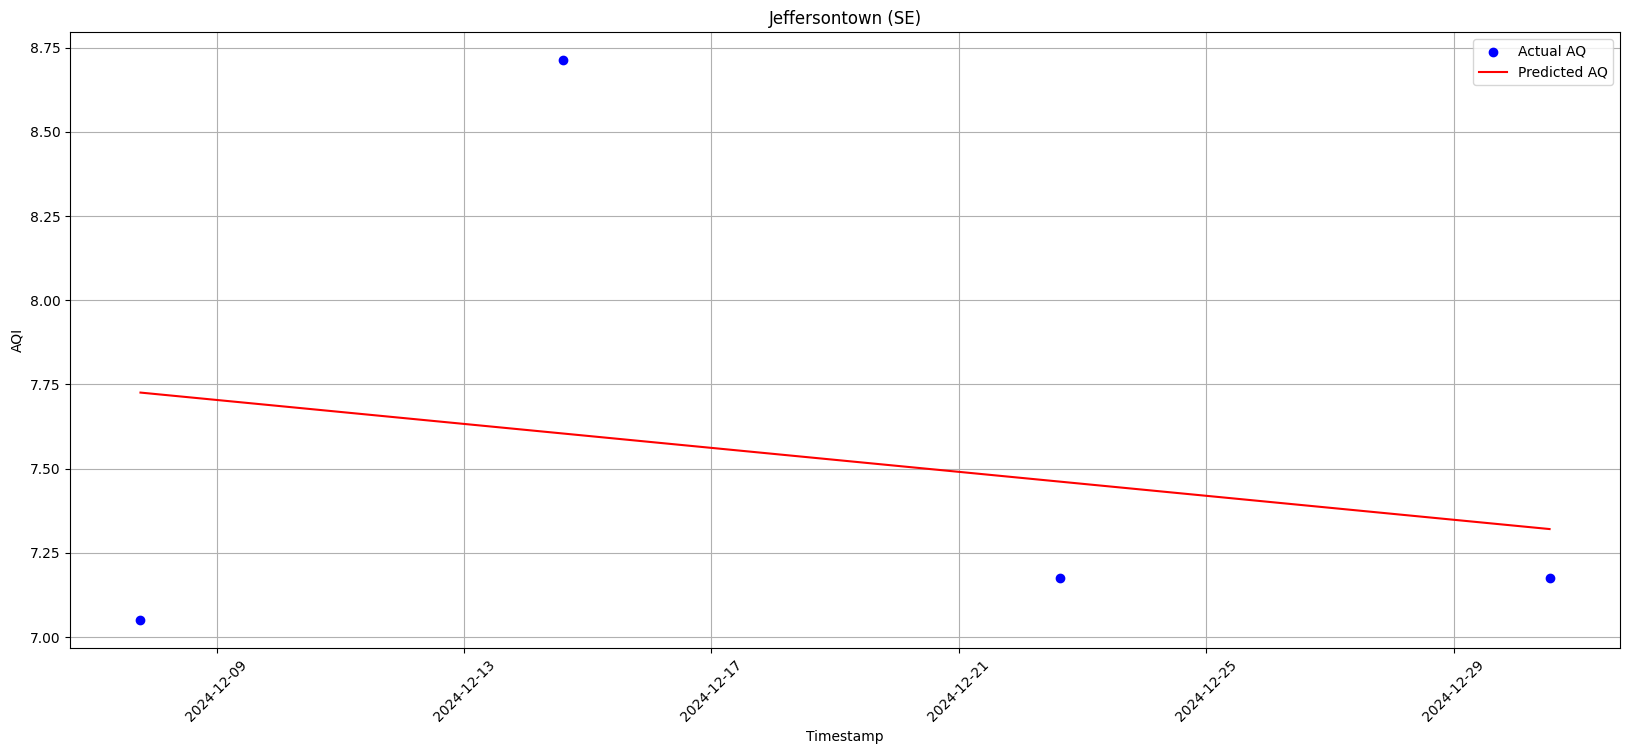

/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_34747/1456205753.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_location["Datetime"] = pd.to_datetime(df_location["float_time"], unit='s')


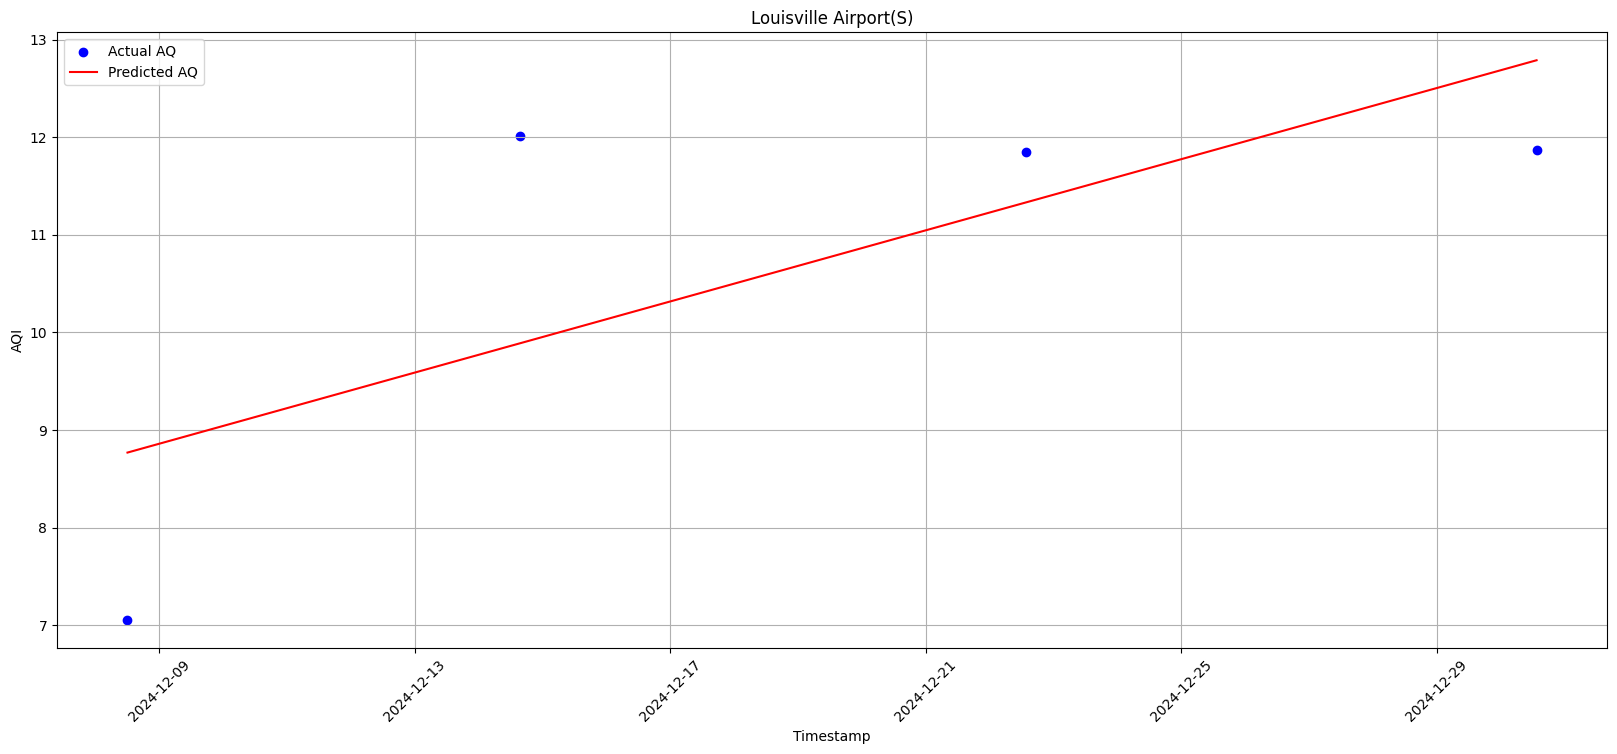

/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_34747/1456205753.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_location["Datetime"] = pd.to_datetime(df_location["float_time"], unit='s')


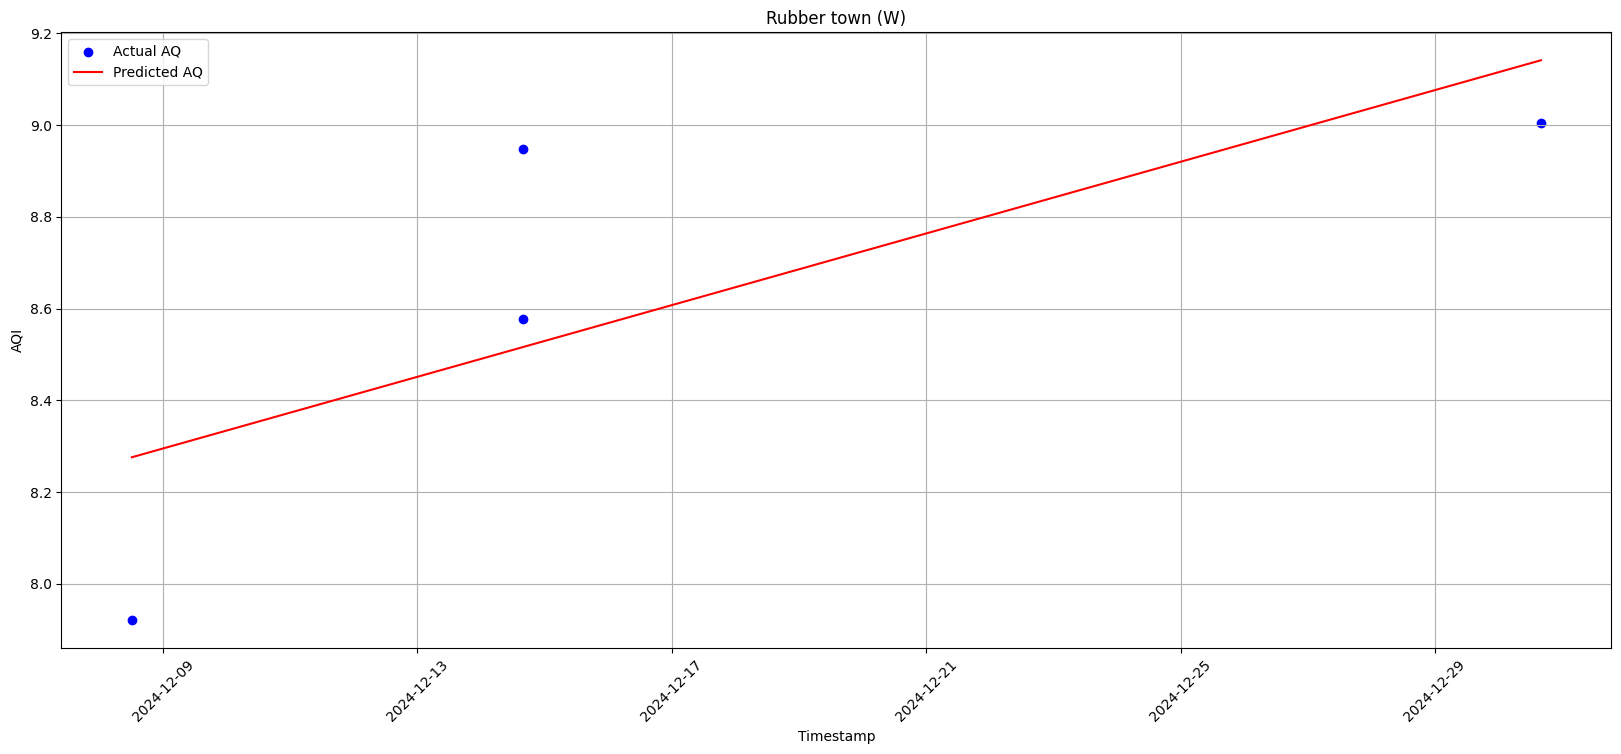

/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_34747/1456205753.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_location["Datetime"] = pd.to_datetime(df_location["float_time"], unit='s')


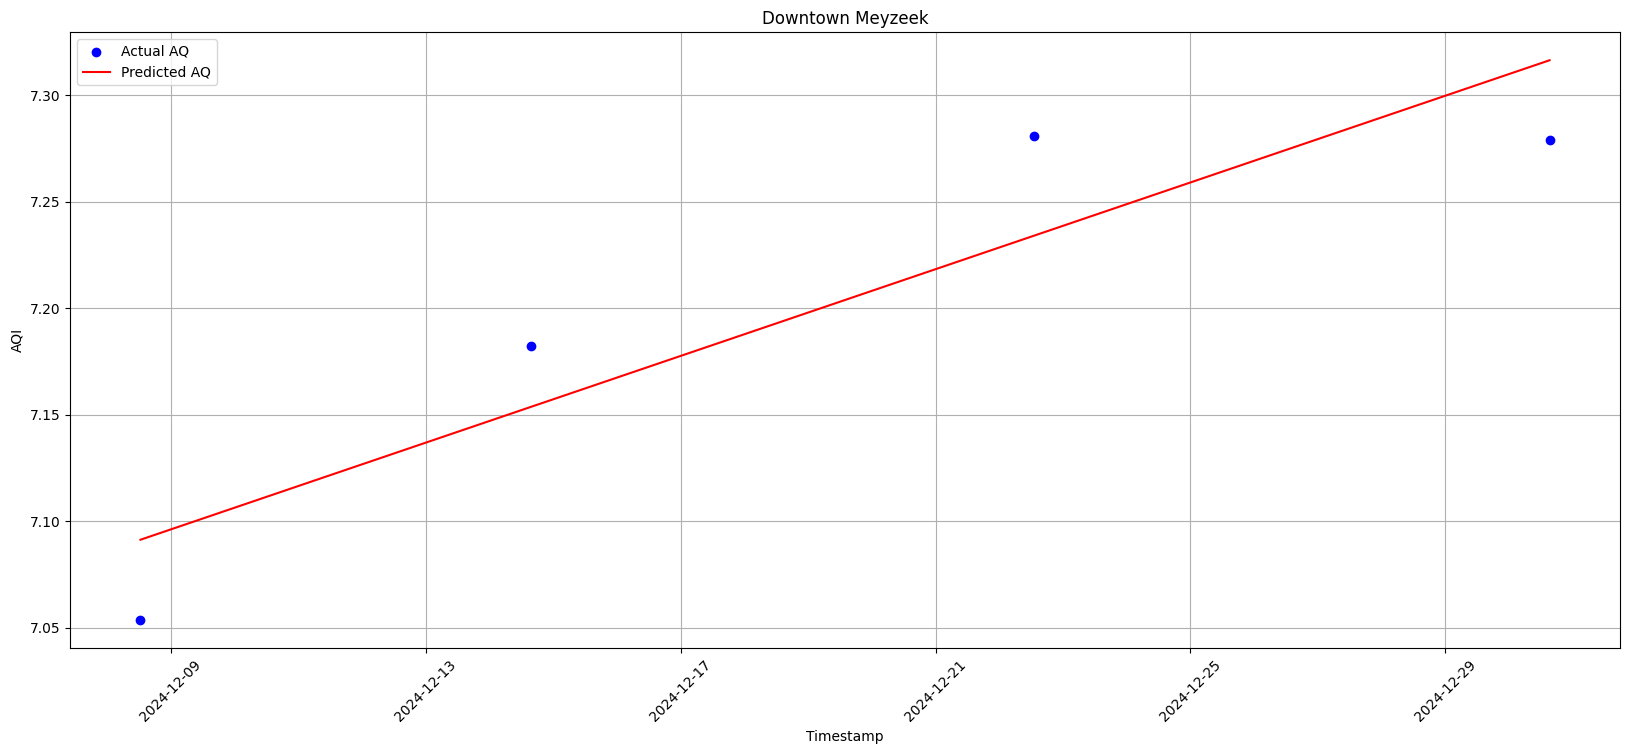

/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_34747/1456205753.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_location["Datetime"] = pd.to_datetime(df_location["float_time"], unit='s')


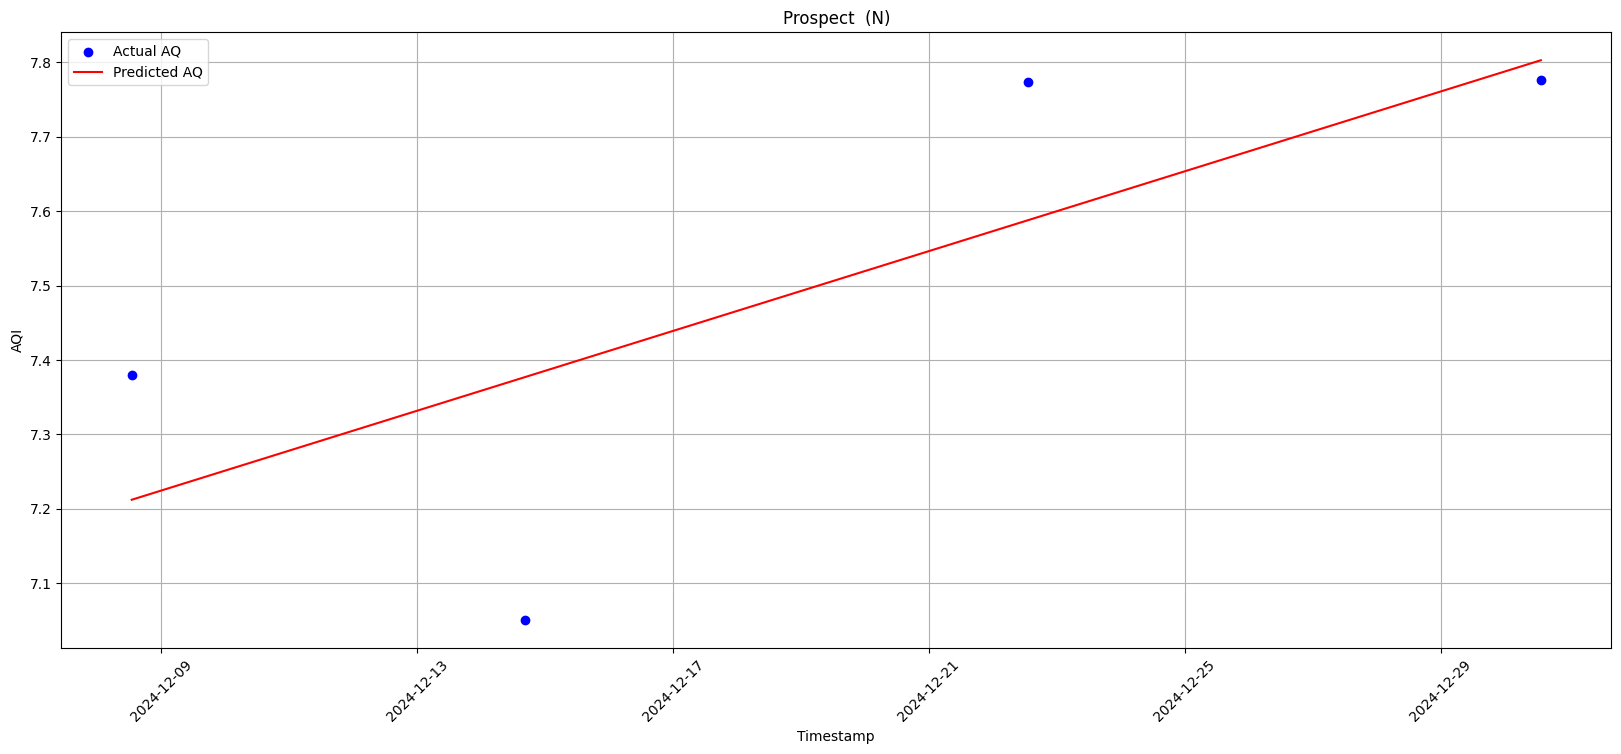

In [500]:
unique_locations = df_meas["Area"].unique()

for i, location in enumerate(unique_locations):
    df_location = df_meas.query(f"Area == '{location}'")
    
    X_train = np.array(df_location[["float_time"]])
    y_train = np.array(df_location[["AQI"]])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    plt.figure(figsize=(20,8))
    df_location["Datetime"] = pd.to_datetime(df_location["float_time"], unit='s')
    plt.scatter(df_location["Datetime"], y_train, color="blue", label="Actual AQ")
    plt.plot(df_location["Datetime"], y_pred, color="red", label="Predicted AQ")
    plt.grid()
    plt.xticks(rotation=45)
    plt.title(location)
    plt.xlabel("Timestamp")
    plt.ylabel("AQI")
    plt.legend()
    plt.show()


In [501]:
df_west["float_time"] = df_west["Time/Date"].apply(lambda x: x.timestamp())
df_east

,Area,Coordinates,Time/Date,CO2 (ppm),TVOC (Total Volatile Organic compounds) (mg),HCHO (Formaldehyde) (mg),Temperature (Degrees F),Air humidity (fraction),loc_clusters,CO2 (mg),AQI,Date
3,Flat rock road (E),38.26705 N 85.44206 W,2024-12-07 15:30:00,416,0.015,0.005,41,0.20,2,0.180835,7.239408,2024-12-07
2,Jeffersontown (SE),38.18642 N 85.56060 W,2024-12-07 18:30:00,405,0.020,0.006,39,0.20,2,0.176054,7.049940,2024-12-07
9,Jeffersontown (SE),38.18642 N 85.56060 W,2024-12-14 14:30:00,500,0.047,0.014,53,0.40,2,0.217350,8.712300,2024-12-14
10,Flat rock road (E),38.26705 N 85.44206 W,2024-12-14 15:30:00,416,0.015,0.005,41,0.20,2,0.180835,7.239408,2024-12-14
16,Jeffersontown (SE),38.18642 N 85.56060 W,2024-12-22 15:10:00,412,0.021,0.014,34,0.20,2,0.179096,7.174356,2024-12-22
17,Flat rock road (E),38.26705 N 85.44206 W,2024-12-22 15:32:00,412,0.048,0.012,34,0.27,2,0.179096,7.181856,2024-12-22
23,Jeffersontown (SE),38.18642 N 85.56060 W,2024-12-30 13:09:00,412,0.022,0.017,34,0.20,2,0.179096,7.175556,2024-12-30
24,Flat rock road (E),38.26705 N 85.44206 W,2024-12-30 14:18:00,412,0.044,0.011,34,0.27,2,0.179096,7.180356,2024-12-30


In [502]:
X_train = np.array(df_west[["float_time"]])
y_train = np.array(df_west[["AQI"]])

model.fit(X_train, y_train)
y_pred = model.predict(X_train)

##### Now plotting each cluster 0-2 -> west, central, eastern respectively

/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_34747/3755262674.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster["Datetime"] = pd.to_datetime(df_cluster["float_time"], unit='s')


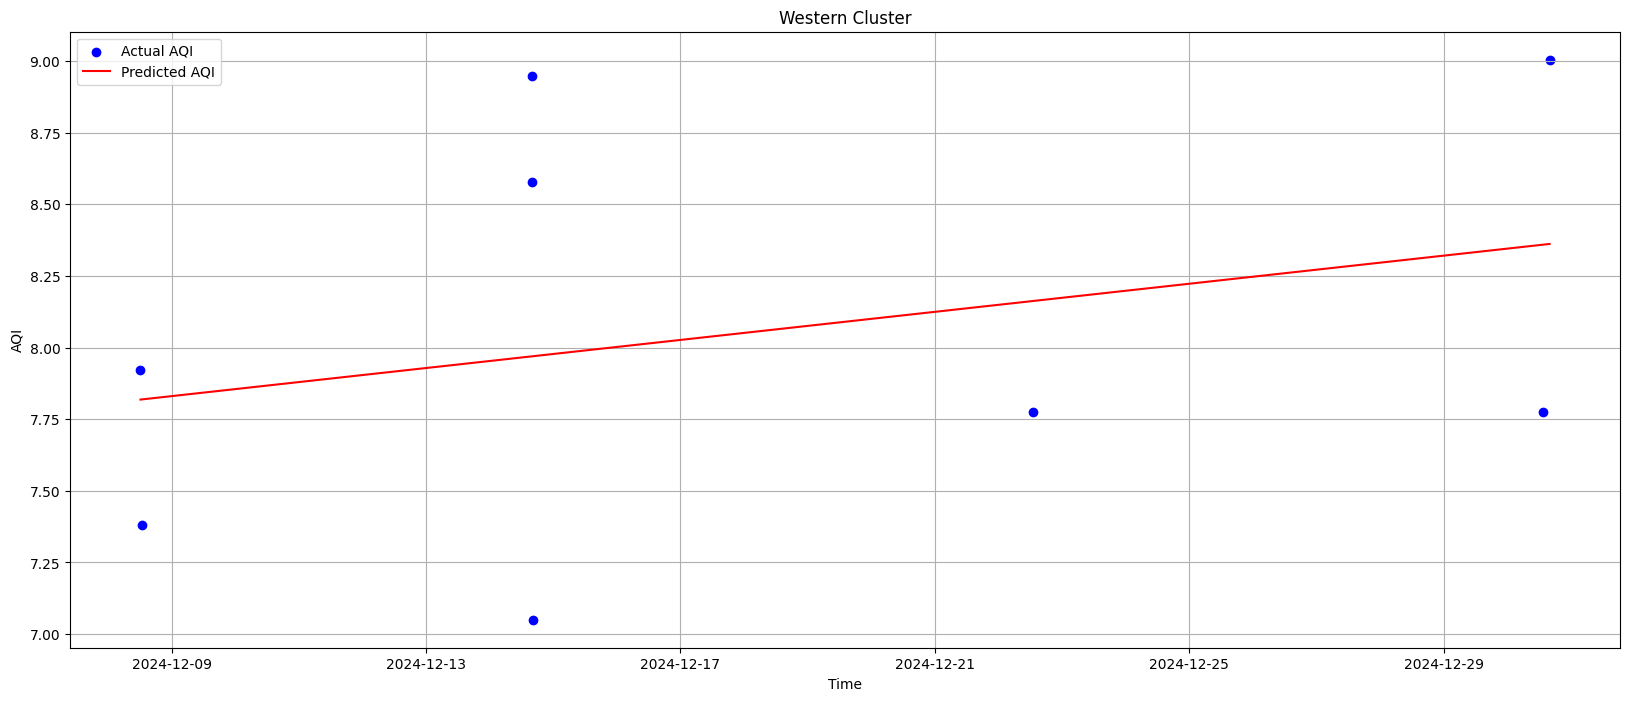

/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_34747/3755262674.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_timestamps = pd.date_range(start="2024-11-01", end="2025-12-31", freq="M")
/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_34747/3755262674.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster["Datetime"] = pd.to_datetime(df_cluster["float_time"], unit='s')


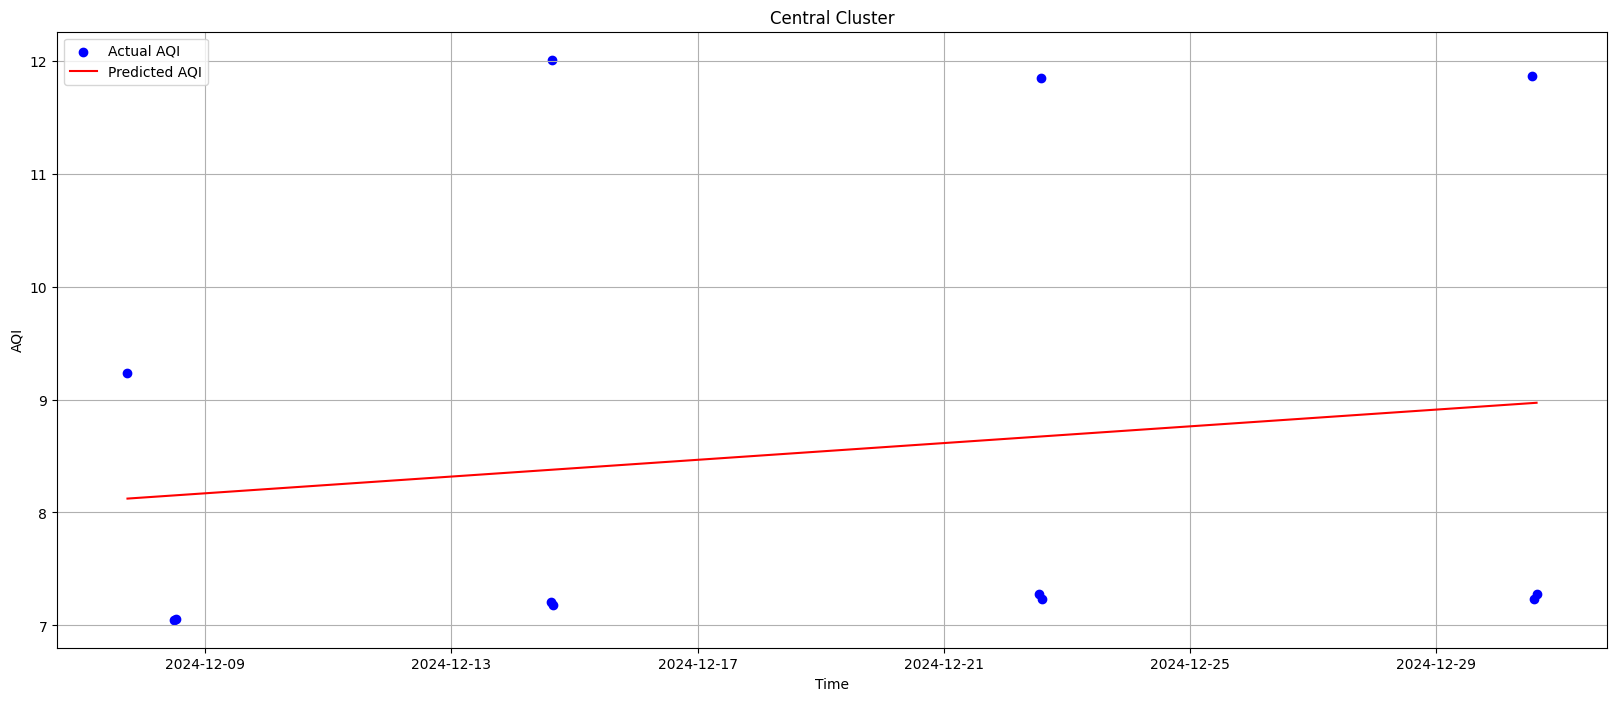

/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_34747/3755262674.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_timestamps = pd.date_range(start="2024-11-01", end="2025-12-31", freq="M")
/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_34747/3755262674.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster["Datetime"] = pd.to_datetime(df_cluster["float_time"], unit='s')


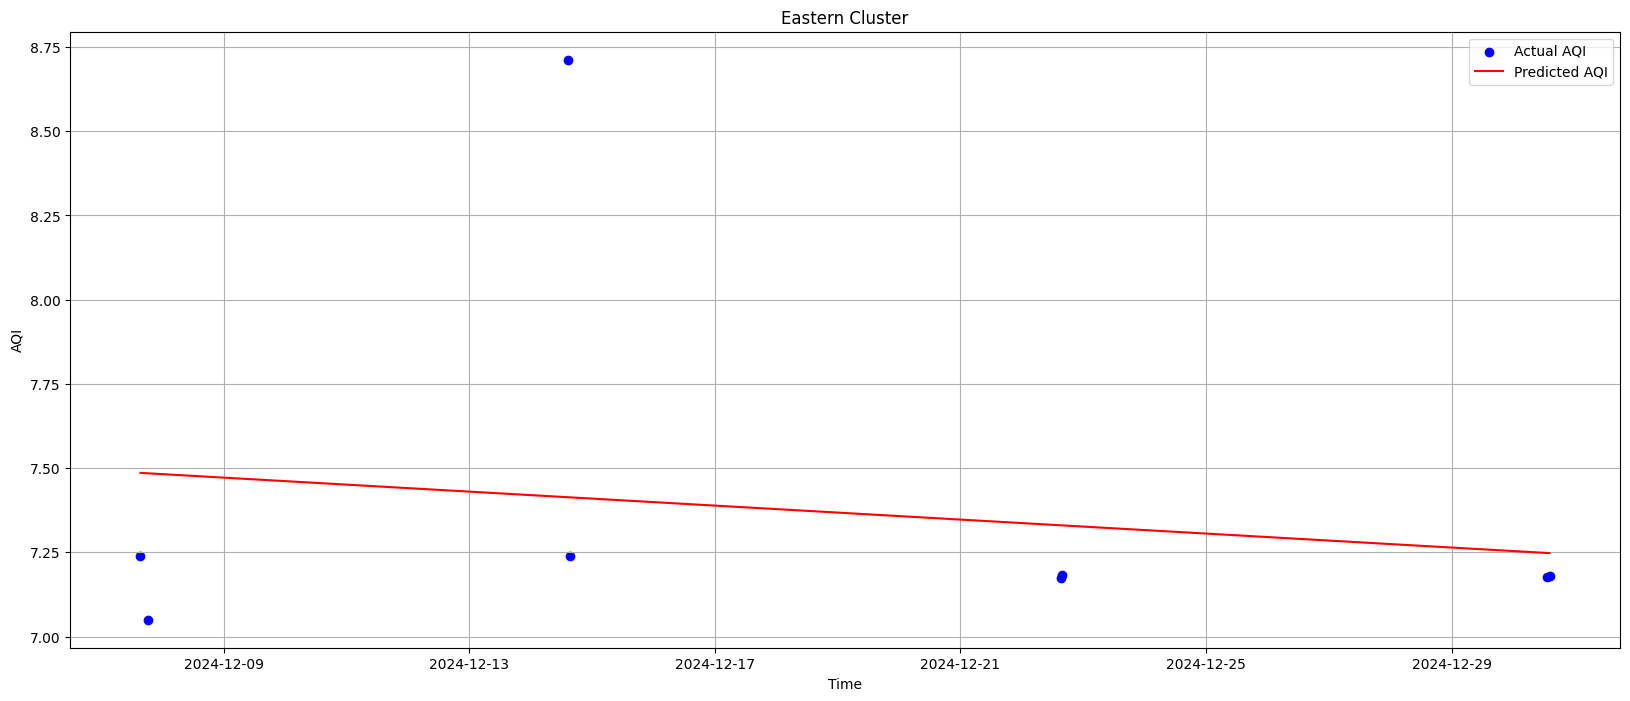

/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_34747/3755262674.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_timestamps = pd.date_range(start="2024-11-01", end="2025-12-31", freq="M")


In [503]:
future_predictions = pd.DataFrame()

for i in range(3):
    df_cluster = df_meas.query(f"loc_clusters == {i}")

    X_train = np.array(df_cluster[["float_time"]])
    y_train = np.array(df_cluster[["AQI"]])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    
    plt.figure(figsize=(20, 8))
    df_cluster["Datetime"] = pd.to_datetime(df_cluster["float_time"], unit='s')
    plt.scatter(df_cluster["Datetime"], y_train, color="blue", label="Actual AQI")
    plt.plot(df_cluster["Datetime"], y_pred, color="red", label="Predicted AQI")
    plt.grid()
    location = "Western" if i == 0 else ("Central" if i == 1 else "Eastern")
    plt.title(f"{location} Cluster")
    plt.xlabel("Time")
    plt.ylabel("AQI")
    plt.legend()
    plt.show()

    future_timestamps = pd.date_range(start="2024-11-01", end="2025-12-31", freq="M")
    future_float_time = future_timestamps.map(lambda x: x.timestamp()).values.reshape(-1, 1)
    future_aqi_pred = model.predict(future_float_time)

    future_df = pd.DataFrame({
        "Cluster": location,
        "Datetime": future_timestamps,
        "float_time": future_float_time.flatten(),
        "Predicted AQI": future_aqi_pred.flatten()
    })

    future_predictions = pd.concat([future_predictions, future_df], ignore_index=True)



In [504]:
future_predictions

,Cluster,Datetime,float_time,Predicted AQI
0,Western,2024-11-30,1.732925e+09,7.609952
1,Western,2024-12-31,1.735603e+09,8.369834
2,Western,2025-01-31,1.738282e+09,9.129715
3,Western,2025-02-28,1.740701e+09,9.816060
4,Western,2025-03-31,1.743379e+09,10.575941
5,Western,2025-04-30,1.745971e+09,11.311311
6,Western,2025-05-31,1.748650e+09,12.071192
7,Western,2025-06-30,1.751242e+09,12.806561
8,Western,2025-07-31,1.753920e+09,13.566443
9,Western,2025-08-31,1.756598e+09,14.326324


In [505]:
future_prediction_western = future_predictions.query("Cluster == 'Western'")
future_prediction_central = future_predictions.query("Cluster == 'Central'")
future_prediction_eastern = future_predictions.query("Cluster == 'Eastern'")

In [506]:
df_west_cluster = df_meas.query(f"loc_clusters == {0}")
df_west_cluster = df_west_cluster.sort_values(by="Time/Date")
df_west_cluster

,Area,Coordinates,Time/Date,CO2 (ppm),TVOC (Total Volatile Organic compounds) (mg),HCHO (Formaldehyde) (mg),Temperature (Degrees F),Air humidity (fraction),loc_clusters,CO2 (mg),AQI,float_time
0,Rubber town (W),38.21197 N 85.84051 W,2024-12-08 12:15:00,450,0.190,0.130,53,0.29,0,0.195615,7.920600,1.733660e+09
4,Prospect (N),38.24171 N 85.84051 W,2024-12-08 12:52:00,424,0.015,0.010,54,0.31,0,0.184313,7.380012,1.733662e+09
7,Rubber town (W),38.21197 N 85.84051 W,2024-12-14 16:00:00,492,0.058,0.018,51,0.27,0,0.213872,8.577696,1.734192e+09
14,Rubber town (W),38.21197 N 85.84051 W,2024-12-14 16:00:00,513,0.065,0.025,51,0.27,0,0.223001,8.947044,1.734192e+09
11,Prospect (N),38.24171 N 85.84051 W,2024-12-14 16:22:00,405,0.020,0.007,51,0.27,0,0.176054,7.050240,1.734193e+09
18,Prospect (N),38.24171 N 85.84051 W,2024-12-22 13:00:00,445,0.065,0.056,34,0.20,0,0.193442,7.773960,1.734872e+09
25,Prospect (N),38.24171 N 85.84051 W,2024-12-30 13:37:00,445,0.071,0.056,34,0.20,0,0.193442,7.775760,1.735566e+09
21,Rubber town (W),38.21197 N 85.84051 W,2024-12-30 16:00:00,516,0.073,0.035,51,0.27,0,0.224305,9.004608,1.735574e+09


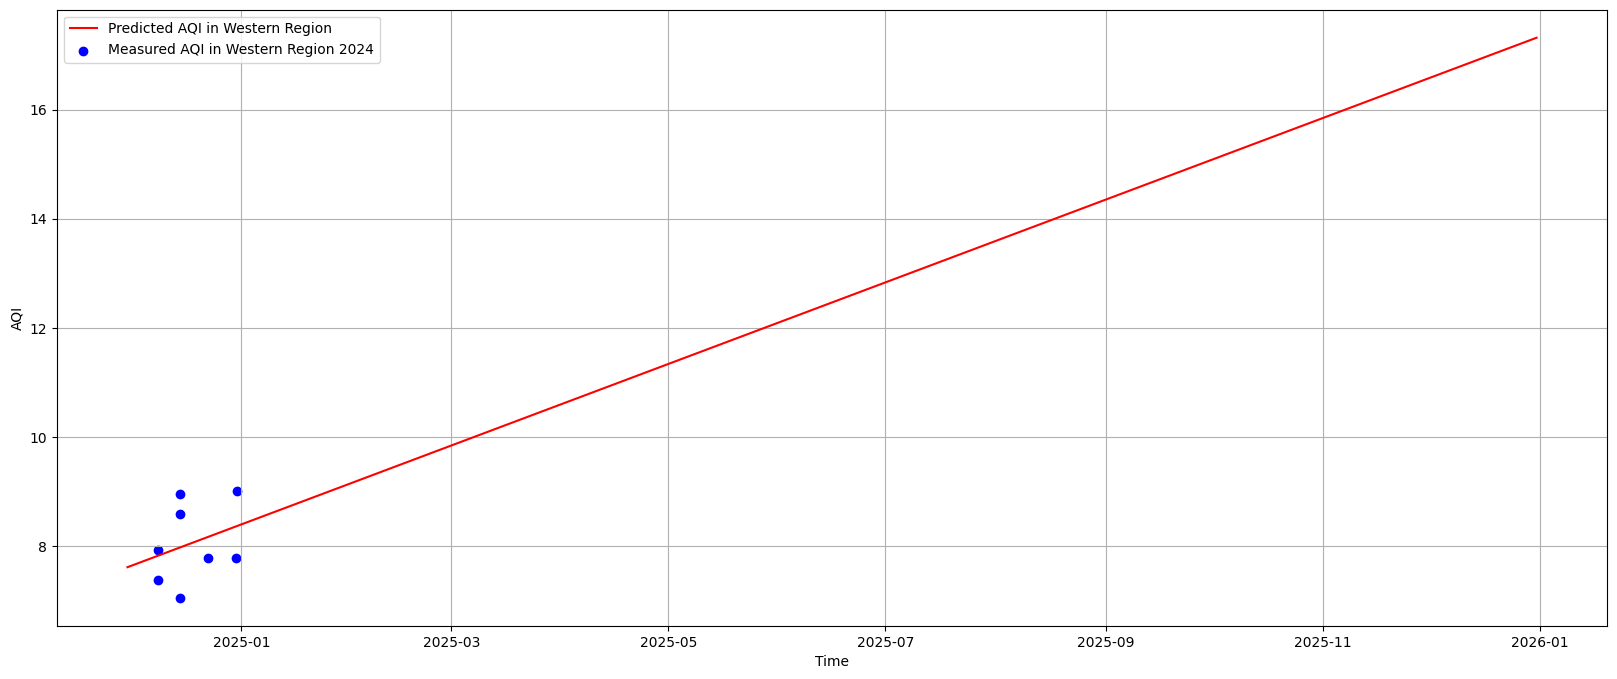

17.31682588722748


In [507]:
plt.figure(figsize=(20, 8))
plt.plot(sorted(future_prediction_western["Datetime"]), future_prediction_western["Predicted AQI"], label="Predicted AQI in Western Region", color="red")
plt.scatter(df_west_cluster["Time/Date"], df_west_cluster["AQI"], color="blue", label="Measured AQI in Western Region 2024")
plt.xlabel("Time")
plt.ylabel("AQI")
plt.grid()
plt.legend()
plt.show()
print(future_prediction_western["Predicted AQI"].iloc[-1])

In [508]:
df_cent_cluster = df_meas.query(f"loc_clusters == {1}")
df_cent_cluster = df_cent_cluster.sort_values(by="Time/Date")
df_cent_cluster

,Area,Coordinates,Time/Date,CO2 (ppm),TVOC (Total Volatile Organic compounds) (mg),HCHO (Formaldehyde) (mg),Temperature (Degrees F),Air humidity (fraction),loc_clusters,CO2 (mg),AQI,float_time
5,Mid-town,38.18888 N 85.64317 W,2024-12-07 17:40:00,530,0.062,0.011,40,0.60,1,0.230391,9.237540,1.733593e+09
1,Louisville Airport(S),38.18604 N 85.74339 W,2024-12-08 11:58:00,405,0.020,0.008,52,0.36,1,0.176054,7.050540,1.733659e+09
6,Downtown Meyzeek,38.24171 N 85.74769 W,2024-12-08 12:36:00,405,0.026,0.012,54,0.39,1,0.176054,7.053540,1.733661e+09
12,Mid-town,38.18888 N 85.64317 W,2024-12-14 15:00:00,414,0.022,0.014,53,0.24,1,0.179966,7.209432,1.734188e+09
8,Louisville Airport(S),38.18604 N 85.74339 W,2024-12-14 15:20:00,689,0.074,0.021,52,0.30,1,0.299508,12.008832,1.734190e+09
13,Downtown Meyzeek,38.24171 N 85.74769 W,2024-12-14 15:35:00,412,0.050,0.012,52,0.34,1,0.179096,7.182456,1.734190e+09
20,Downtown Meyzeek,38.24171 N 85.74769 W,2024-12-22 13:13:00,418,0.025,0.017,35,0.30,1,0.181705,7.280784,1.734873e+09
15,Louisville Airport(S),38.18604 N 85.74339 W,2024-12-22 13:45:00,680,0.071,0.019,36,0.31,1,0.295596,11.850840,1.734875e+09
19,Mid-town,38.18888 N 85.64317 W,2024-12-22 14:20:00,415,0.047,0.016,35,0.21,1,0.180400,7.234920,1.734877e+09
22,Louisville Airport(S),38.18604 N 85.74339 W,2024-12-30 13:35:00,681,0.074,0.019,36,0.31,1,0.296031,11.869128,1.735566e+09


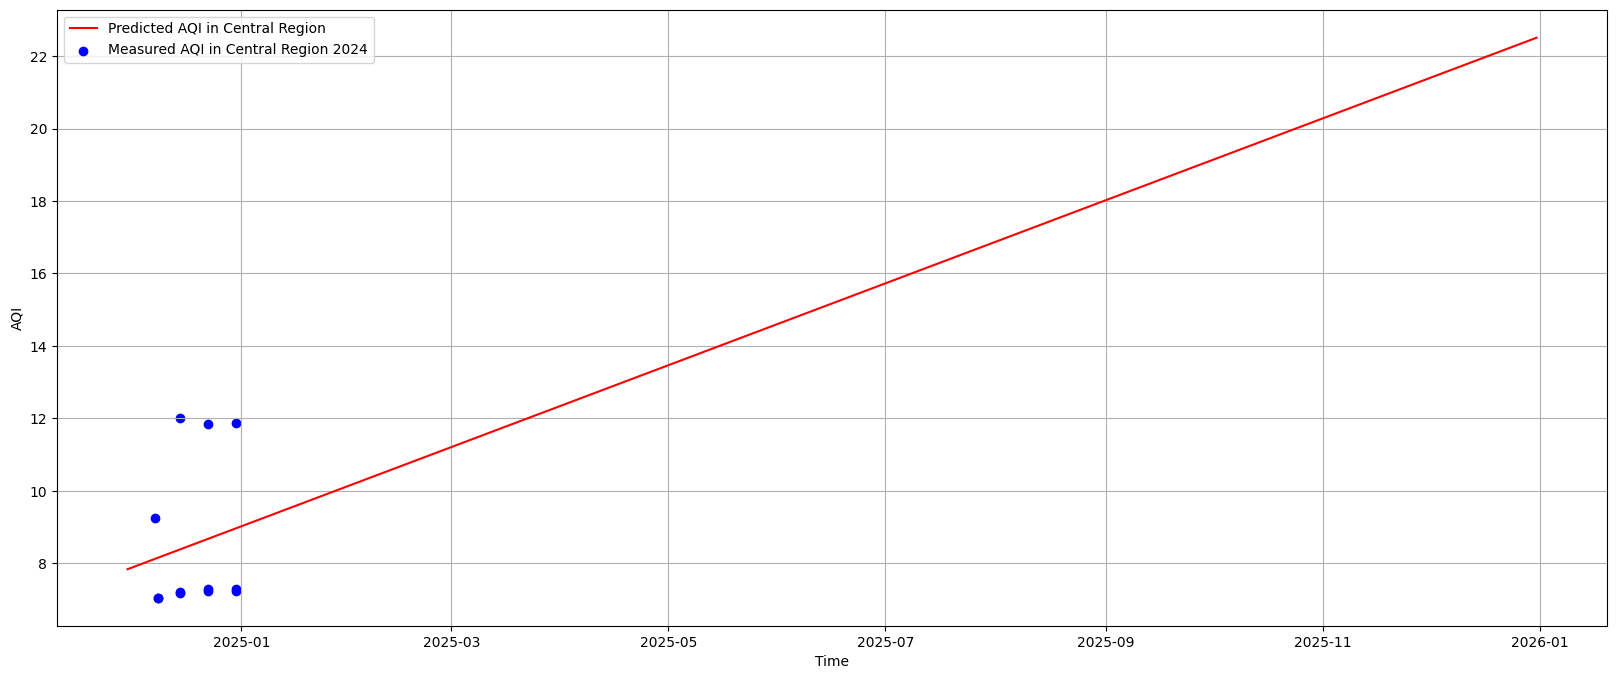

22.50702480091104


In [509]:
plt.figure(figsize=(20, 8))
plt.plot(sorted(future_prediction_central["Datetime"]), future_prediction_central["Predicted AQI"], label="Predicted AQI in Central Region", color="red")
plt.scatter(df_cent_cluster["Time/Date"], df_cent_cluster["AQI"], color="blue", label="Measured AQI in Central Region 2024")
plt.xlabel("Time")
plt.ylabel("AQI")
plt.grid()
plt.legend()
plt.show()
print(future_prediction_central["Predicted AQI"].iloc[-1])

In [510]:
df_east_cluster = df_meas.query(f"loc_clusters == {2}")
df_east_cluster = df_east_cluster.sort_values(by="Time/Date")
df_east_cluster

,Area,Coordinates,Time/Date,CO2 (ppm),TVOC (Total Volatile Organic compounds) (mg),HCHO (Formaldehyde) (mg),Temperature (Degrees F),Air humidity (fraction),loc_clusters,CO2 (mg),AQI,float_time
3,Flat rock road (E),38.26705 N 85.44206 W,2024-12-07 15:30:00,416,0.015,0.005,41,0.20,2,0.180835,7.239408,1.733585e+09
2,Jeffersontown (SE),38.18642 N 85.56060 W,2024-12-07 18:30:00,405,0.020,0.006,39,0.20,2,0.176054,7.049940,1.733596e+09
9,Jeffersontown (SE),38.18642 N 85.56060 W,2024-12-14 14:30:00,500,0.047,0.014,53,0.40,2,0.217350,8.712300,1.734187e+09
10,Flat rock road (E),38.26705 N 85.44206 W,2024-12-14 15:30:00,416,0.015,0.005,41,0.20,2,0.180835,7.239408,1.734190e+09
16,Jeffersontown (SE),38.18642 N 85.56060 W,2024-12-22 15:10:00,412,0.021,0.014,34,0.20,2,0.179096,7.174356,1.734880e+09
17,Flat rock road (E),38.26705 N 85.44206 W,2024-12-22 15:32:00,412,0.048,0.012,34,0.27,2,0.179096,7.181856,1.734882e+09
23,Jeffersontown (SE),38.18642 N 85.56060 W,2024-12-30 13:09:00,412,0.022,0.017,34,0.20,2,0.179096,7.175556,1.735564e+09
24,Flat rock road (E),38.26705 N 85.44206 W,2024-12-30 14:18:00,412,0.044,0.011,34,0.27,2,0.179096,7.180356,1.735568e+09


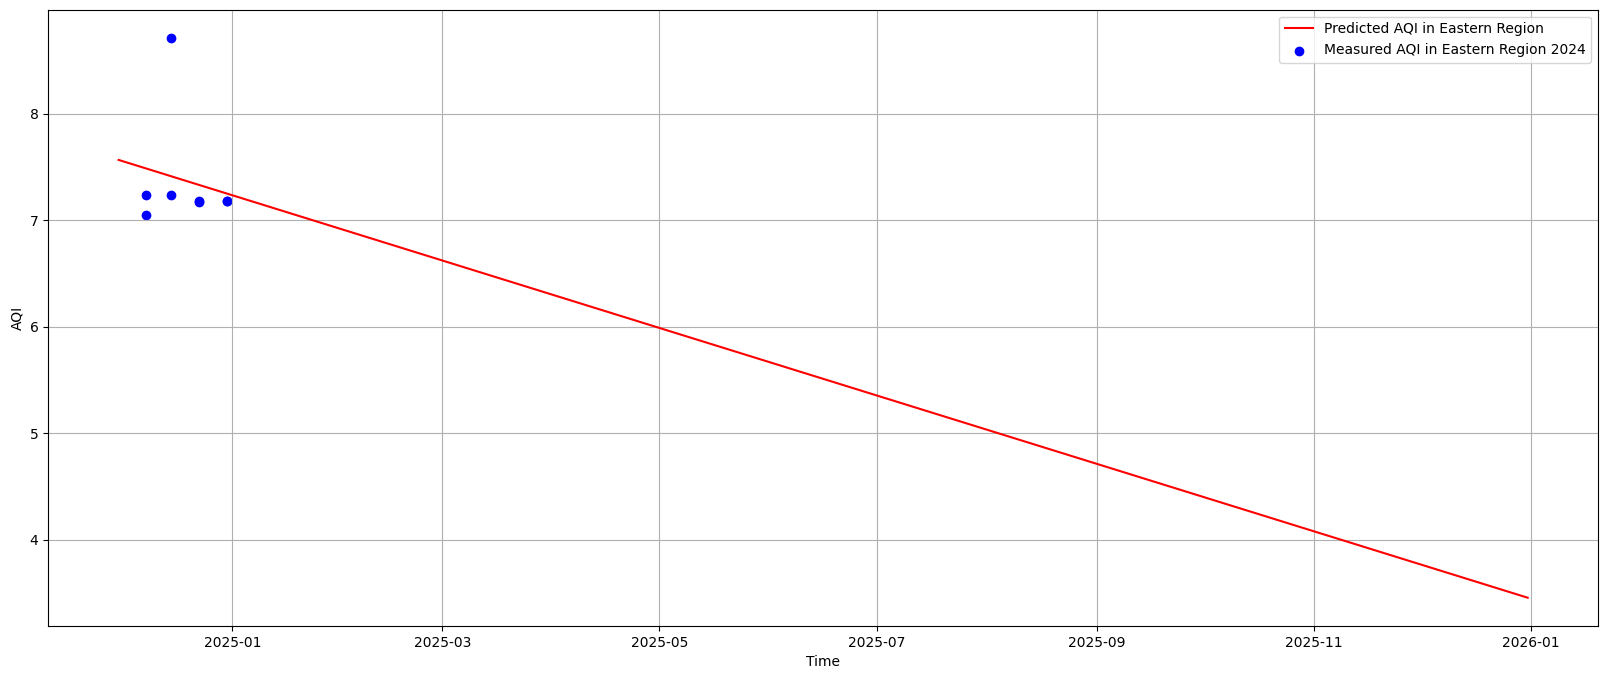

22.50702480091104


In [512]:
plt.figure(figsize=(20, 8))
plt.plot(sorted(future_prediction_eastern["Datetime"]), future_prediction_eastern["Predicted AQI"], label="Predicted AQI in Eastern Region", color="red")
plt.scatter(df_east_cluster["Time/Date"], df_east_cluster["AQI"], color="blue", label="Measured AQI in Eastern Region 2024")
plt.xlabel("Time")
plt.ylabel("AQI")
plt.grid()
plt.legend()
plt.show()
print(future_prediction_central["Predicted AQI"].iloc[-1])